In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import pandas as pd
from adjustText import adjust_text
import random
from model_structure import get_preprocessing_transforms,BCNN, train_model, evaluate_model

In [6]:
INPUT_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device('cpu') # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def read_data():
    # Get transforms
    train_transform, val_transform = get_preprocessing_transforms(INPUT_SIZE)

    test_data_1_dir = 'data4model_1/test/'
    test_data_2_dir = 'data4model_2/test/'
    train_data_1_dir = 'data4model_1/train/'
    train_data_2_dir = 'data4model_2/train/'

    # Load data set
    dataset_test_1 = datasets.ImageFolder(test_data_1_dir,transform=val_transform)
    dataset_train_1 = datasets.ImageFolder(train_data_1_dir,transform=train_transform)
    dataset_test_2 = datasets.ImageFolder(test_data_2_dir,transform=val_transform)
    dataset_train_2 = datasets.ImageFolder(train_data_2_dir,transform=train_transform)

    test_loader_1 = DataLoader(dataset_test_1, shuffle=False, batch_size=BATCH_SIZE)
    train_loader_1 = DataLoader(dataset_train_1, shuffle=False, batch_size=BATCH_SIZE)
    test_loader_2 = DataLoader(dataset_test_2, shuffle=False, batch_size=BATCH_SIZE)
    train_loader_2 = DataLoader(dataset_train_2, shuffle=False, batch_size=BATCH_SIZE)

    return {"Model_1:Train": train_loader_1,
            "Model_1:Test": test_loader_1,
            "Model_2:Train": train_loader_2,
            "Model_2:Test": test_loader_2}

In [8]:
model_1_dir = 'best_model_1.pth'
model_2_dir = 'best_model_2.pth'

In [9]:
# Load the model
model_1 = BCNN().to(DEVICE)
weights = torch.load(model_1_dir, map_location=torch.device(DEVICE))
model_1.load_state_dict(weights)
model_1.eval()

model_2 = BCNN().to(DEVICE)
weights = torch.load(model_2_dir, map_location=torch.device(DEVICE))
model_2.load_state_dict(weights)
model_2.eval()

C:\Users\hskay\AppData\Local\Temp\ipykernel_21572\1438434258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_1_dir, map_location=torch.device(

BCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigm

In [10]:
dataSets = read_data()

In [11]:
for key in dataSets:
    print(key)
    if "Model_1" in key:
        model = model_1
    else:
        model = model_2
    
    results = evaluate_model(model.to(DEVICE), dataSets[key], DEVICE)
    print("Accuracy: ", results[0])
    print("F1 Score: ", results[1])
    print("confusion Matrix: \n",results[3])
    print("\n")

Model_1:Train
Accuracy:  0.9116666666666666
F1 Score:  0.9106239460370995
confusion Matrix: 
 [[1385  115]
 [ 150 1350]]


Model_1:Test
Accuracy:  0.875
F1 Score:  0.8743718592964824
confusion Matrix: 
 [[88 12]
 [13 87]]


Model_2:Train
Accuracy:  0.8953333333333333
F1 Score:  0.8934871099050203
confusion Matrix: 
 [[1369  131]
 [ 183 1317]]


Model_2:Test
Accuracy:  0.905
F1 Score:  0.9090909090909091
confusion Matrix: 
 [[86 14]
 [ 5 95]]




In [ ]:
def get_activation(name,model_name):
    def hook(model, input, output):
        activation_values[model_name][name] = output.detach()
    return hook

def register_hooks(model,model_name):
    hooks = []
    layer_info = {}
    counter = 0
    for name, layer in model.named_modules():
        #if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # Register hook for the full layer output
            # hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            
            if isinstance(layer, nn.Linear) and False:
                layer_info[name] = {'type': f'{counter}-linear',}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            elif isinstance(layer, nn.Conv2d) and False:
                layer_info[name] = {'type': f'{counter}-conv'}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            elif isinstance(layer, nn.ReLU):
                 layer_info[name] = {'type': f'{counter}-relu'}
                 hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            # elif isinstance(layer, nn.MaxPool2d):
            #     layer_info[name] = {'type': f'{counter}-maxpool'}
            # elif isinstance(layer, nn.Dropout):
            #     layer_info[name] = {'type': f'{counter}-dropout'}
            # elif isinstance(layer, nn.Flatten):
            #     layer_info[name] = {'type': f'{counter}-flatten'}
            elif isinstance(layer, nn.Sigmoid):
                layer_info[name] = {'type': f'{counter}-sigmoid'}
            # else:
            #     layer_info[name] = {'type': f'{counter}-other'}
            counter += 1
    return hooks, layer_info


def analyze_positive_activations(activations1, activations2,layers1,layers2, pic_index, model1_name="Model 1", model2_name="Model 2",
                                     image=None,  
                                    pred1=None,  
                                    pred2=None):
    def get_layer_stats(activations, layers):
        layer_stats = {}
        for layer_name, layer_data in layers.items():
            activation = activations[layer_name]
            flattened = activation.view(activation.shape[0], -1)
            positive_activations = flattened[flattened > 0]
            
            stats = {
                'count': len(positive_activations),
                'total_neurons': flattened.numel(),
                'percentage_active': (len(positive_activations) / flattened.numel()) * 100,
                'mean': positive_activations.mean().item() if len(positive_activations) > 0 else 0,
                'sum': positive_activations.sum().item(),
                'max': positive_activations.max().item() if len(positive_activations) > 0 else 0,
                'min': positive_activations.min().item() if len(positive_activations) > 0 else 0
            }
            layer_stats[layer_name.split(".")[0]+" "+layers[layer_name]["type"]] = stats
        return layer_stats

    # Get stats for both models
    stats1 = get_layer_stats(activations1,layers1)
    stats2 = get_layer_stats(activations2,layers2)

    # Create combined DataFrame
    combined_stats = {}
    for layer_name in stats1.keys():
        combined_stats[layer_name] = {
            f'data_index':pic_index,
            f'count_{model1_name}': stats1[layer_name]['count'],
            f'count_{model2_name}': stats2[layer_name]['count'],
            f'total_neurons_{model1_name}': stats1[layer_name]['total_neurons'],
            f'total_neurons_{model2_name}': stats2[layer_name]['total_neurons'],
            f'percentage_active_{model1_name}': stats1[layer_name]['percentage_active'],
            f'percentage_active_{model2_name}': stats2[layer_name]['percentage_active'],
            f'mean_{model1_name}': stats1[layer_name]['mean'],
            f'mean_{model2_name}': stats2[layer_name]['mean'],
            f'sum_{model1_name}': stats1[layer_name]['sum'],
            f'sum_{model2_name}': stats2[layer_name]['sum'],
            f'max_{model1_name}': stats1[layer_name]['max'],
            f'max_{model2_name}': stats2[layer_name]['max'],
            f'min_{model1_name}': stats1[layer_name]['min'],
            f'min_{model2_name}': stats2[layer_name]['min']
        }

    df_combined = pd.DataFrame.from_dict(combined_stats, orient='index')
    
    # Print combined statistics
    print("\nCombined Analysis for Both Models:")
    print("=" * 80)
    print(df_combined)
    
    # Create comparison visualizations (same as before)
    fig, axes = plt.subplots(3, 2, figsize=(20, 20))

    # Plot 0 and -1: Image and Predictions
    axes[0, 0].imshow(image.permute(1, 2, 0))
    axes[0, 0].set_title('Image')

    axes[0, 1].bar(['Model 1', 'Model 2'], 
            [pred1.item(), pred2.item()])
    axes[0, 1].set_title('Predictions')
    
    # Plot 1: Percentage of active neurons comparison
    ax1 = axes[1, 0]
    x = np.arange(len(df_combined))
    width = 0.35
    ax1.bar(x - width/2, df_combined[f'percentage_active_{model1_name}'], width, label=model1_name)
    ax1.bar(x + width/2, df_combined[f'percentage_active_{model2_name}'], width, label=model2_name)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_combined.index, rotation=45, ha='right')
    ax1.set_title('Percentage of Active Neurons by Layer')
    ax1.set_ylabel('Percentage (%)')
    ax1.legend()

    # Plot 2: Mean activation value comparison
    ax2 = axes[1, 1]
    ax2.bar(x - width/2, df_combined[f'mean_{model1_name}'], width, label=model1_name)
    ax2.bar(x + width/2, df_combined[f'mean_{model2_name}'], width, label=model2_name)
    ax2.set_xticks(x)
    ax2.set_xticklabels(df_combined.index, rotation=45, ha='right')
    ax2.set_title('Mean Activation Value by Layer')
    ax2.set_ylabel('Mean Value')
    ax2.legend()

    # Plot 3: Total activation sum comparison
    ax3 = axes[2, 0]
    ax3.bar(x - width/2, df_combined[f'sum_{model1_name}'], width, label=model1_name)
    ax3.bar(x + width/2, df_combined[f'sum_{model2_name}'], width, label=model2_name)
    ax3.set_xticks(x)
    ax3.set_xticklabels(df_combined.index, rotation=45, ha='right')
    ax3.set_title('Sum of Activations by Layer')
    ax3.set_ylabel('Sum')
    ax3.legend()

    # Plot 4: Count of active neurons comparison
    ax4 = axes[2, 1]
    ax4.bar(x - width/2, df_combined[f'count_{model1_name}'], width, label=model1_name)
    ax4.bar(x + width/2, df_combined[f'count_{model2_name}'], width, label=model2_name)
    ax4.set_xticks(x)
    ax4.set_xticklabels(df_combined.index, rotation=45, ha='right')
    ax4.set_title('Count of Active Neurons by Layer')
    ax4.set_ylabel('Count')
    ax4.legend()

    plt.tight_layout()
    plt.savefig(f'models_activation_analysis_comparison{pic_index}.png')
    plt.show()

    return df_combined





Combined Analysis for Both Models:
                       data_index  count_Model_1  count_Model_2  \
features 3-relu               100         100227         110856   
features 7-relu               100          97621         168206   
features 11-relu              100           4551          20787   
classifier 17-relu            100             49             71   
classifier 20-sigmoid         100              1              1   

                       total_neurons_Model_1  total_neurons_Model_2  \
features 3-relu                      1605632                1605632   
features 7-relu                       802816                 802816   
features 11-relu                      401408                 401408   
classifier 17-relu                       512                    512   
classifier 20-sigmoid                      1                      1   

                       percentage_active_Model_1  percentage_active_Model_2  \
features 3-relu                         6.242215       

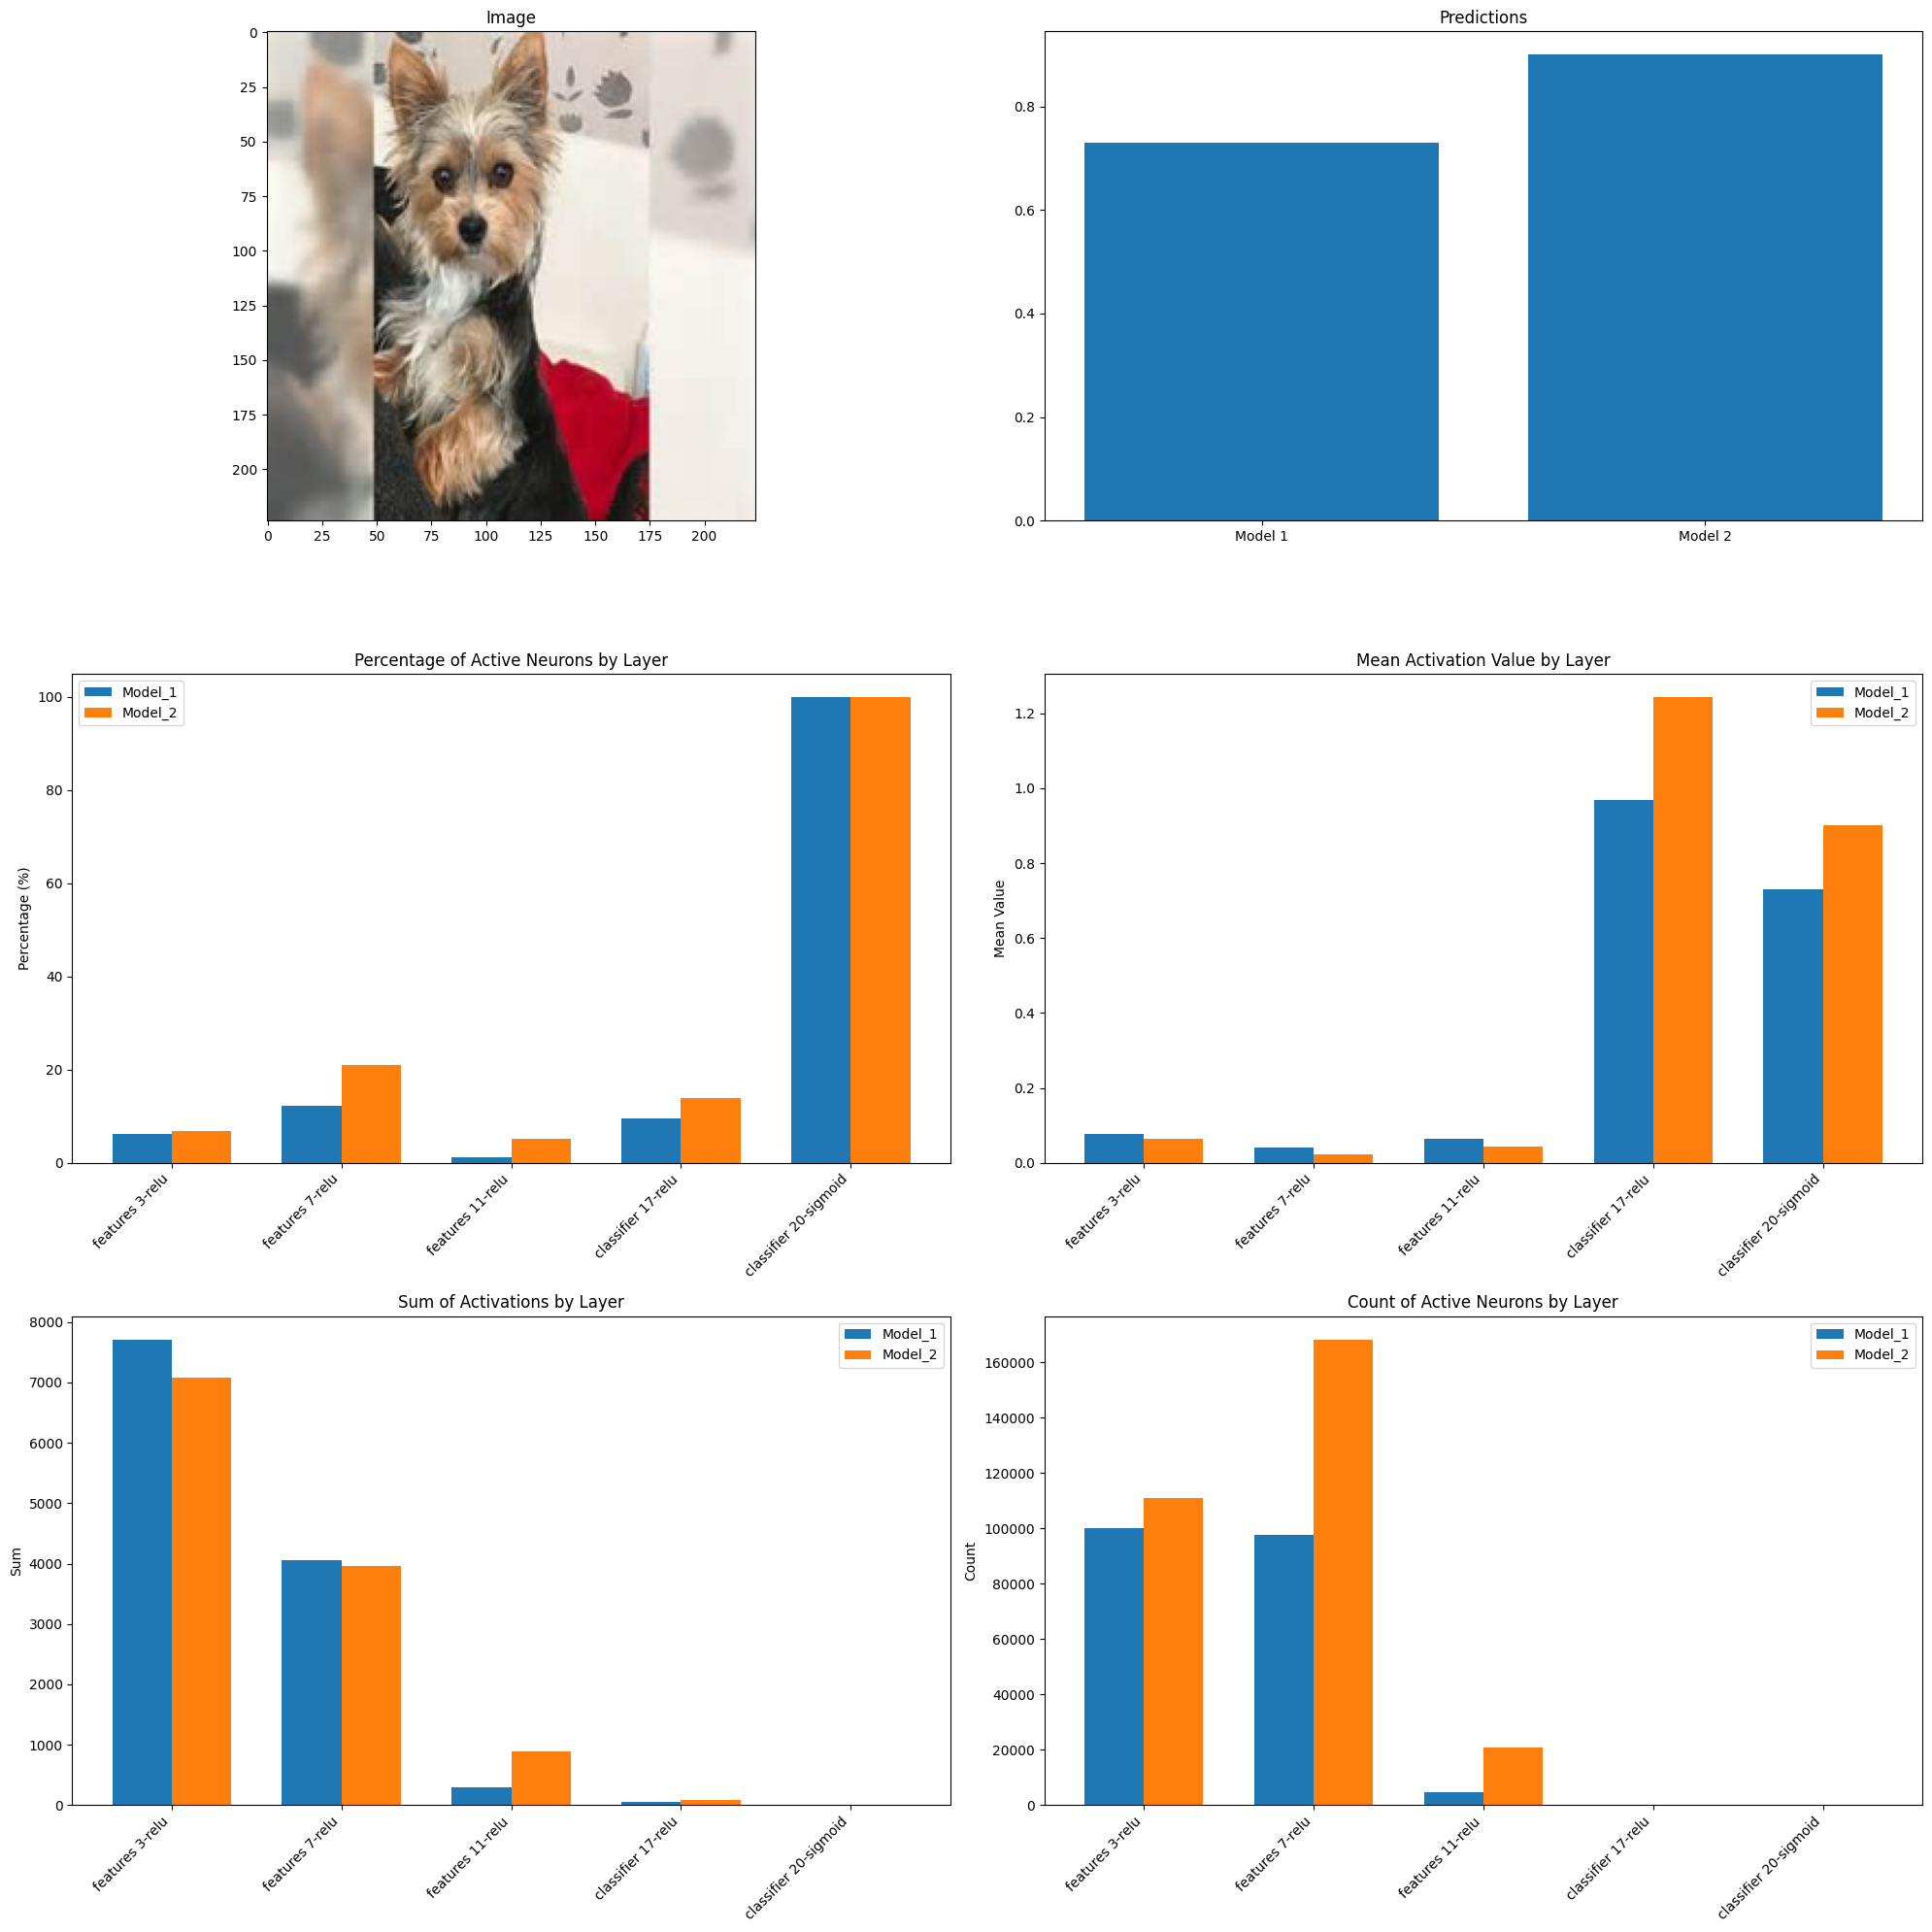


Combined Analysis for Both Models:
                       data_index  count_Model_1  count_Model_2  \
features 3-relu               101         218946         248225   
features 7-relu               101          85727         159765   
features 11-relu              101           6032          10318   
classifier 17-relu            101             59             79   
classifier 20-sigmoid         101              1              1   

                       total_neurons_Model_1  total_neurons_Model_2  \
features 3-relu                      1605632                1605632   
features 7-relu                       802816                 802816   
features 11-relu                      401408                 401408   
classifier 17-relu                       512                    512   
classifier 20-sigmoid                      1                      1   

                       percentage_active_Model_1  percentage_active_Model_2  \
features 3-relu                        13.636126       

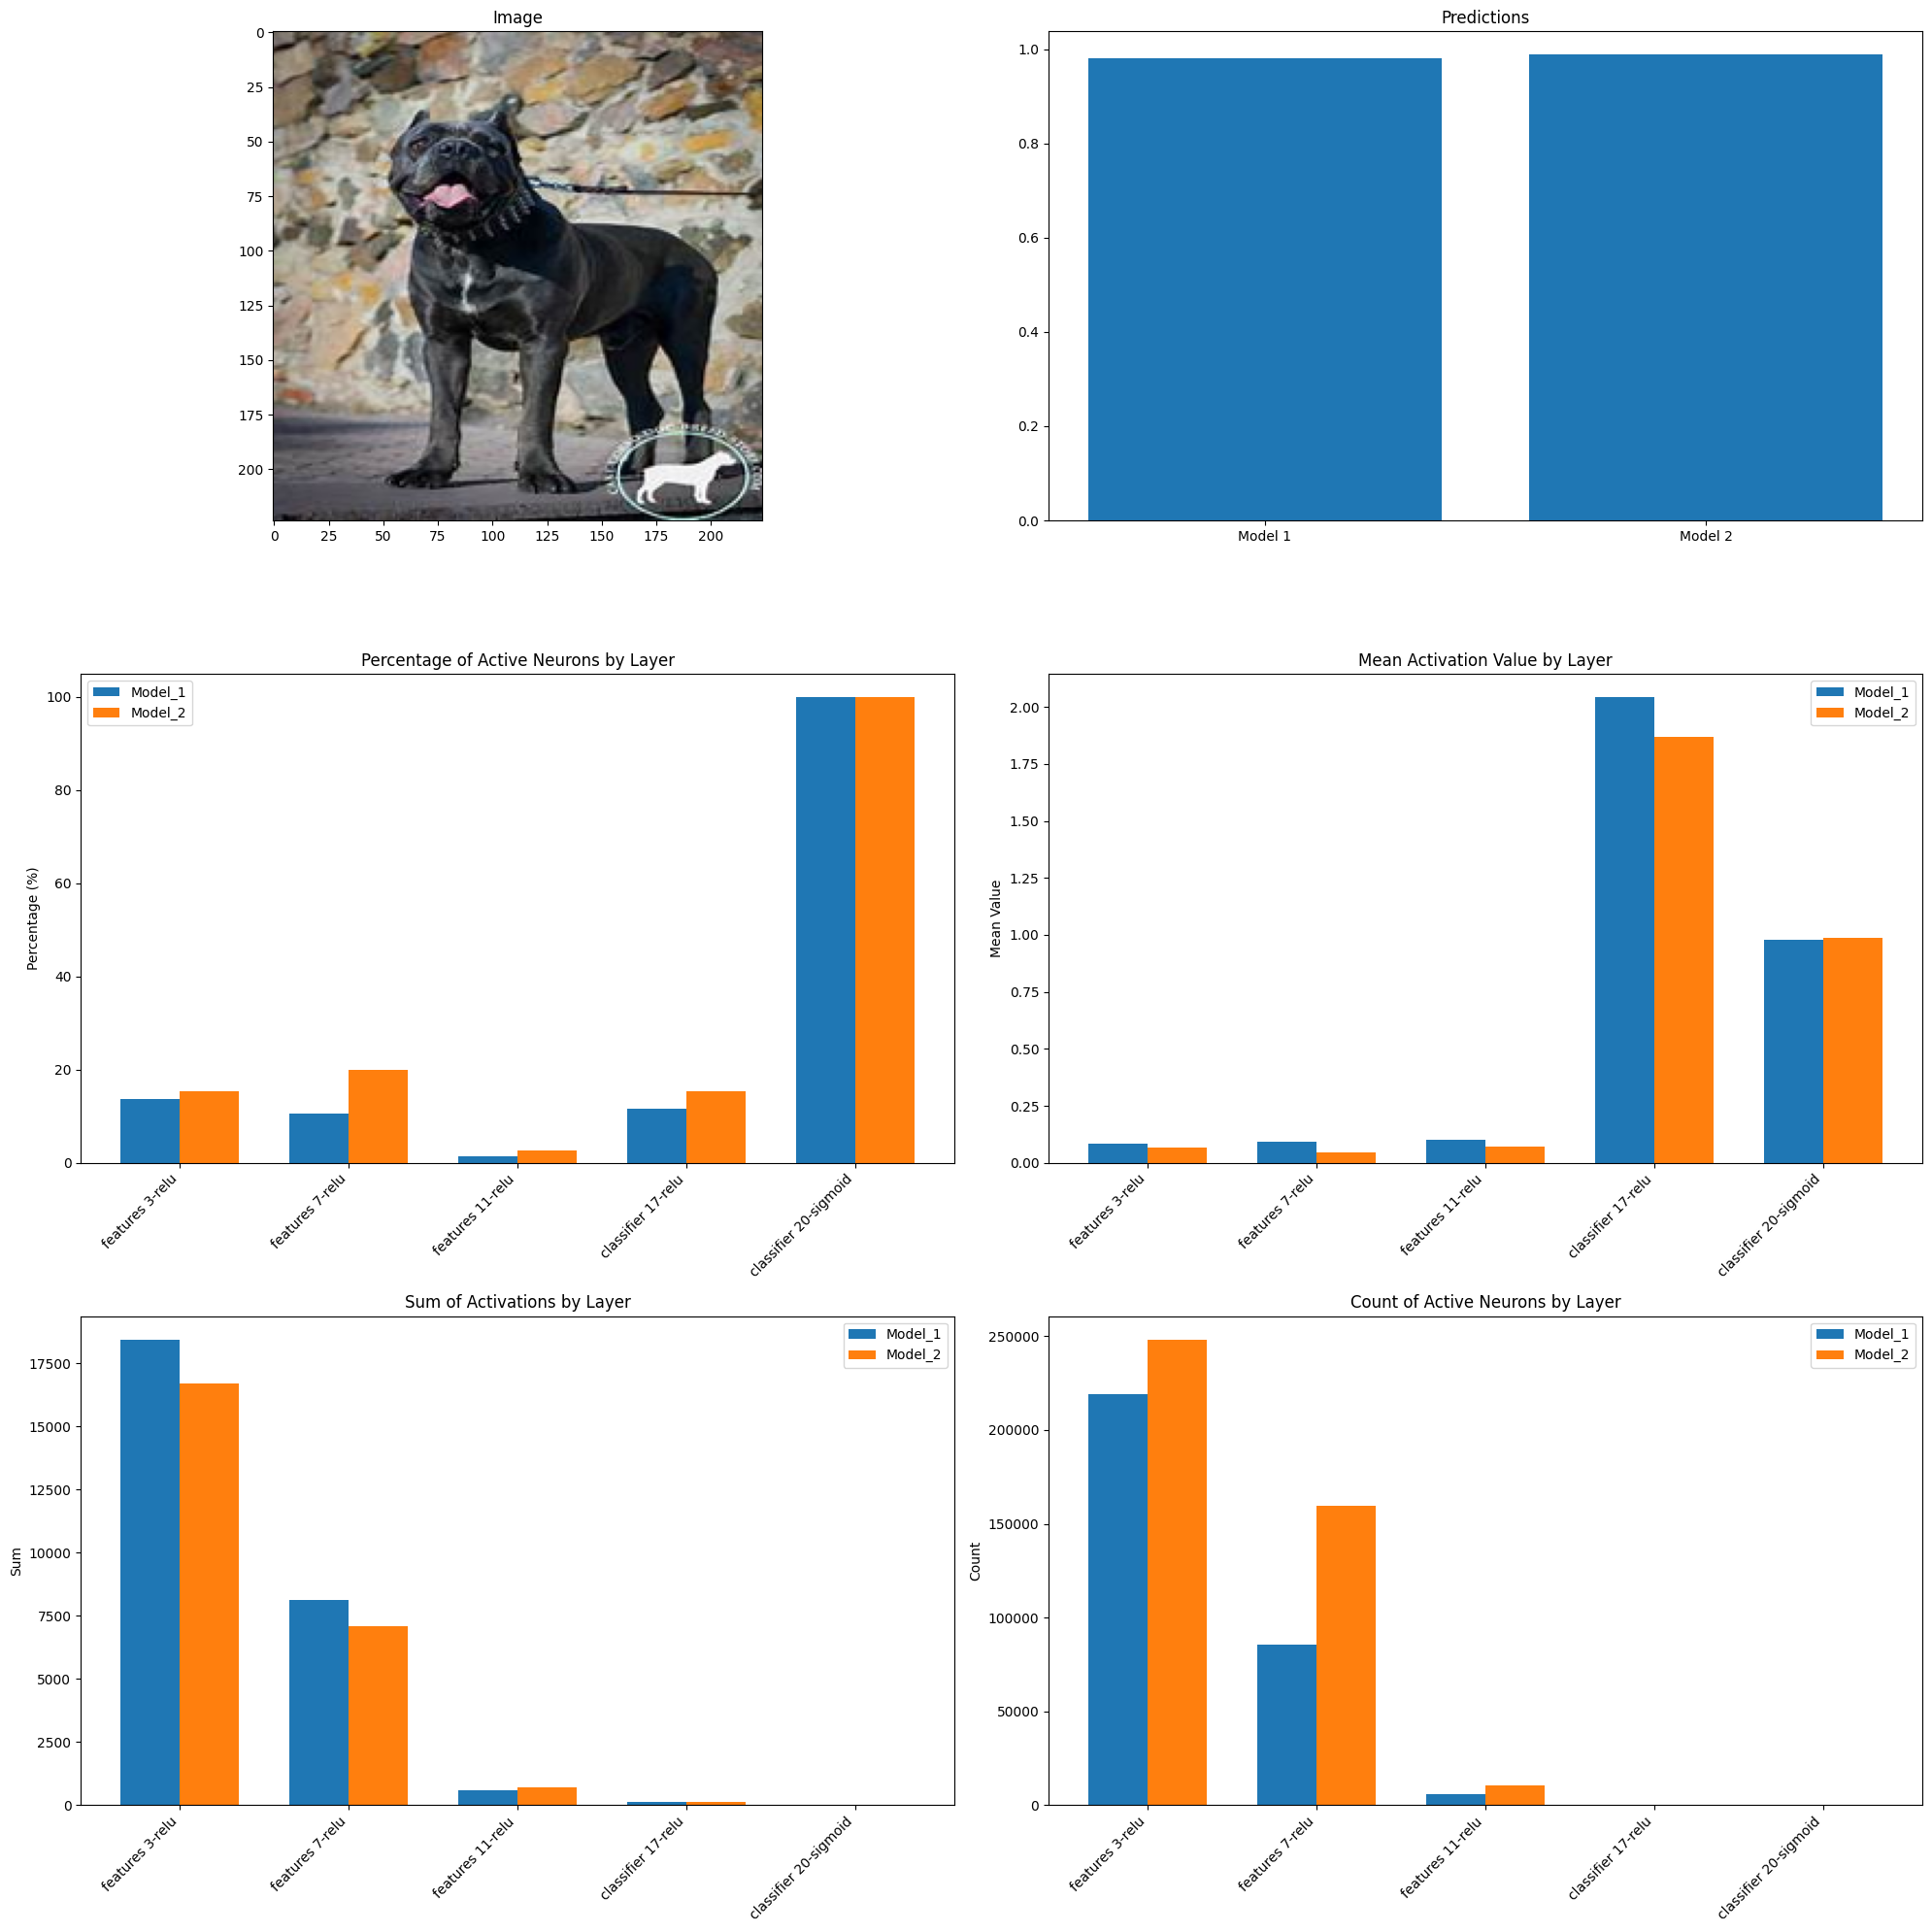


Combined Analysis for Both Models:
                       data_index  count_Model_1  count_Model_2  \
features 3-relu               102         100963         133453   
features 7-relu               102         109995         185482   
features 11-relu              102           3363          15345   
classifier 17-relu            102             65             72   
classifier 20-sigmoid         102              1              1   

                       total_neurons_Model_1  total_neurons_Model_2  \
features 3-relu                      1605632                1605632   
features 7-relu                       802816                 802816   
features 11-relu                      401408                 401408   
classifier 17-relu                       512                    512   
classifier 20-sigmoid                      1                      1   

                       percentage_active_Model_1  percentage_active_Model_2  \
features 3-relu                         6.288054       

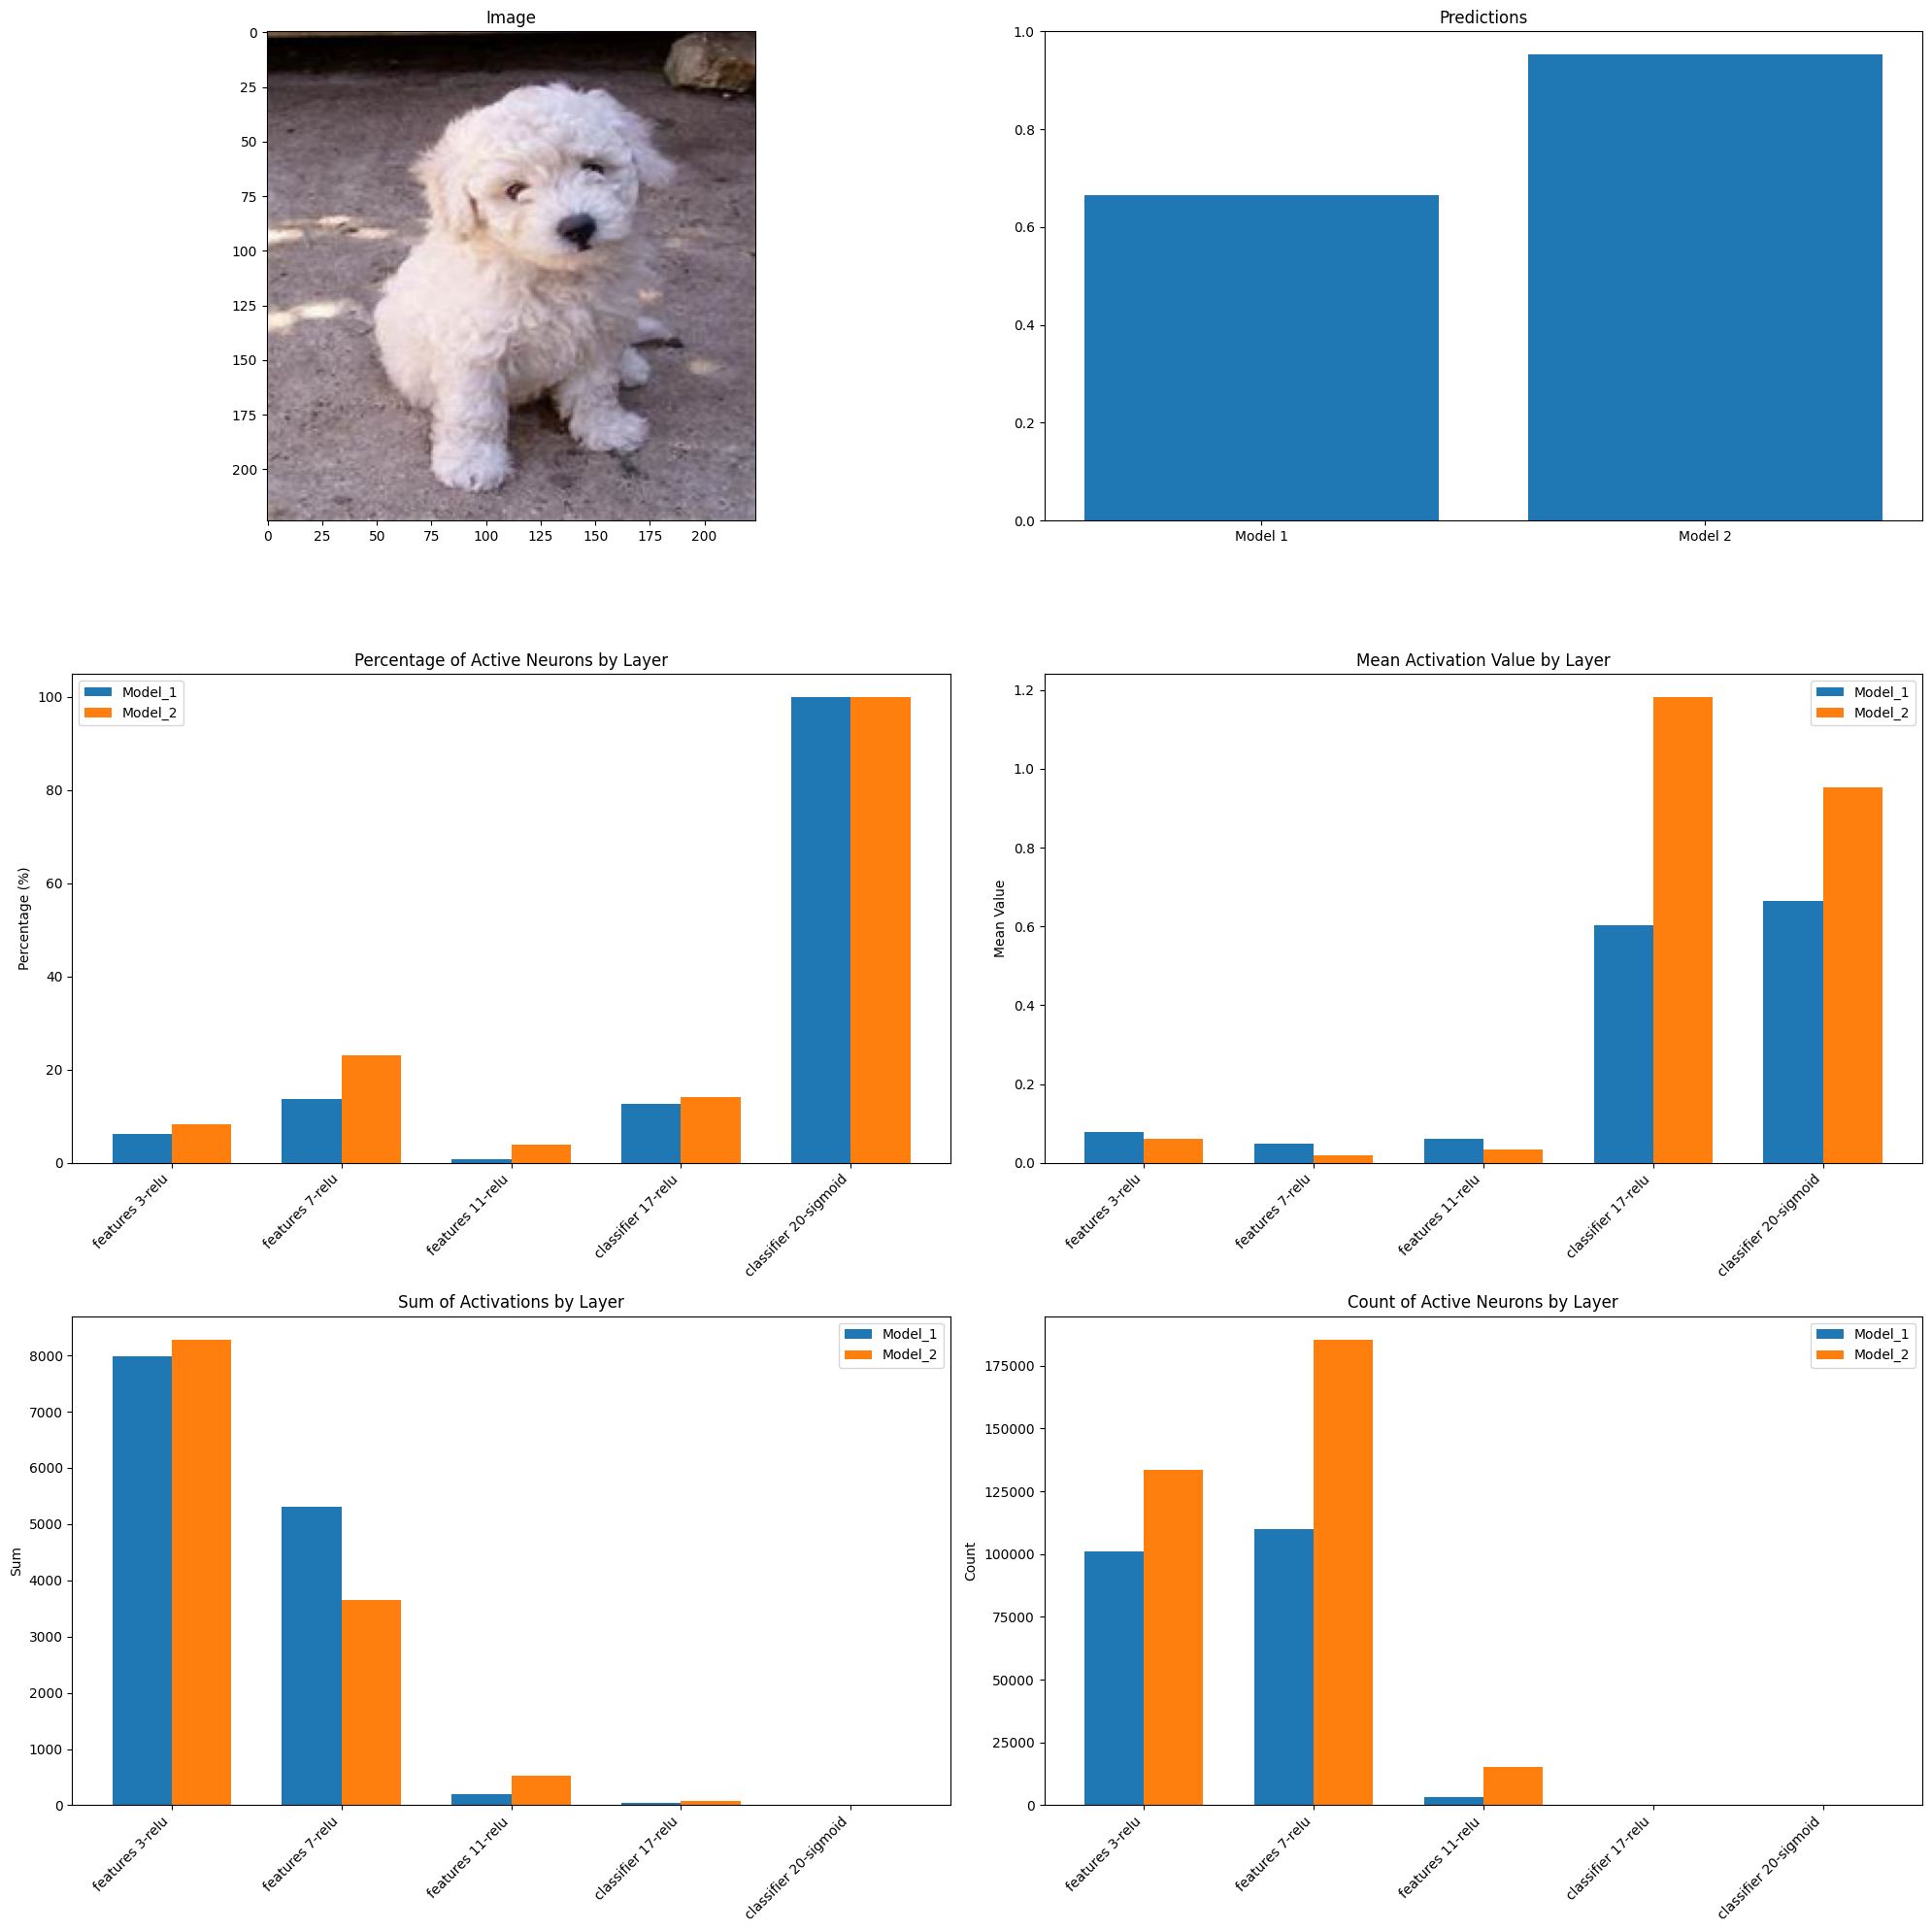


Combined Analysis for Both Models:
                       data_index  count_Model_1  count_Model_2  \
features 3-relu               103          95625         109061   
features 7-relu               103         104676         154122   
features 11-relu              103           4192          24571   
classifier 17-relu            103             98             79   
classifier 20-sigmoid         103              1              1   

                       total_neurons_Model_1  total_neurons_Model_2  \
features 3-relu                      1605632                1605632   
features 7-relu                       802816                 802816   
features 11-relu                      401408                 401408   
classifier 17-relu                       512                    512   
classifier 20-sigmoid                      1                      1   

                       percentage_active_Model_1  percentage_active_Model_2  \
features 3-relu                         5.955599       

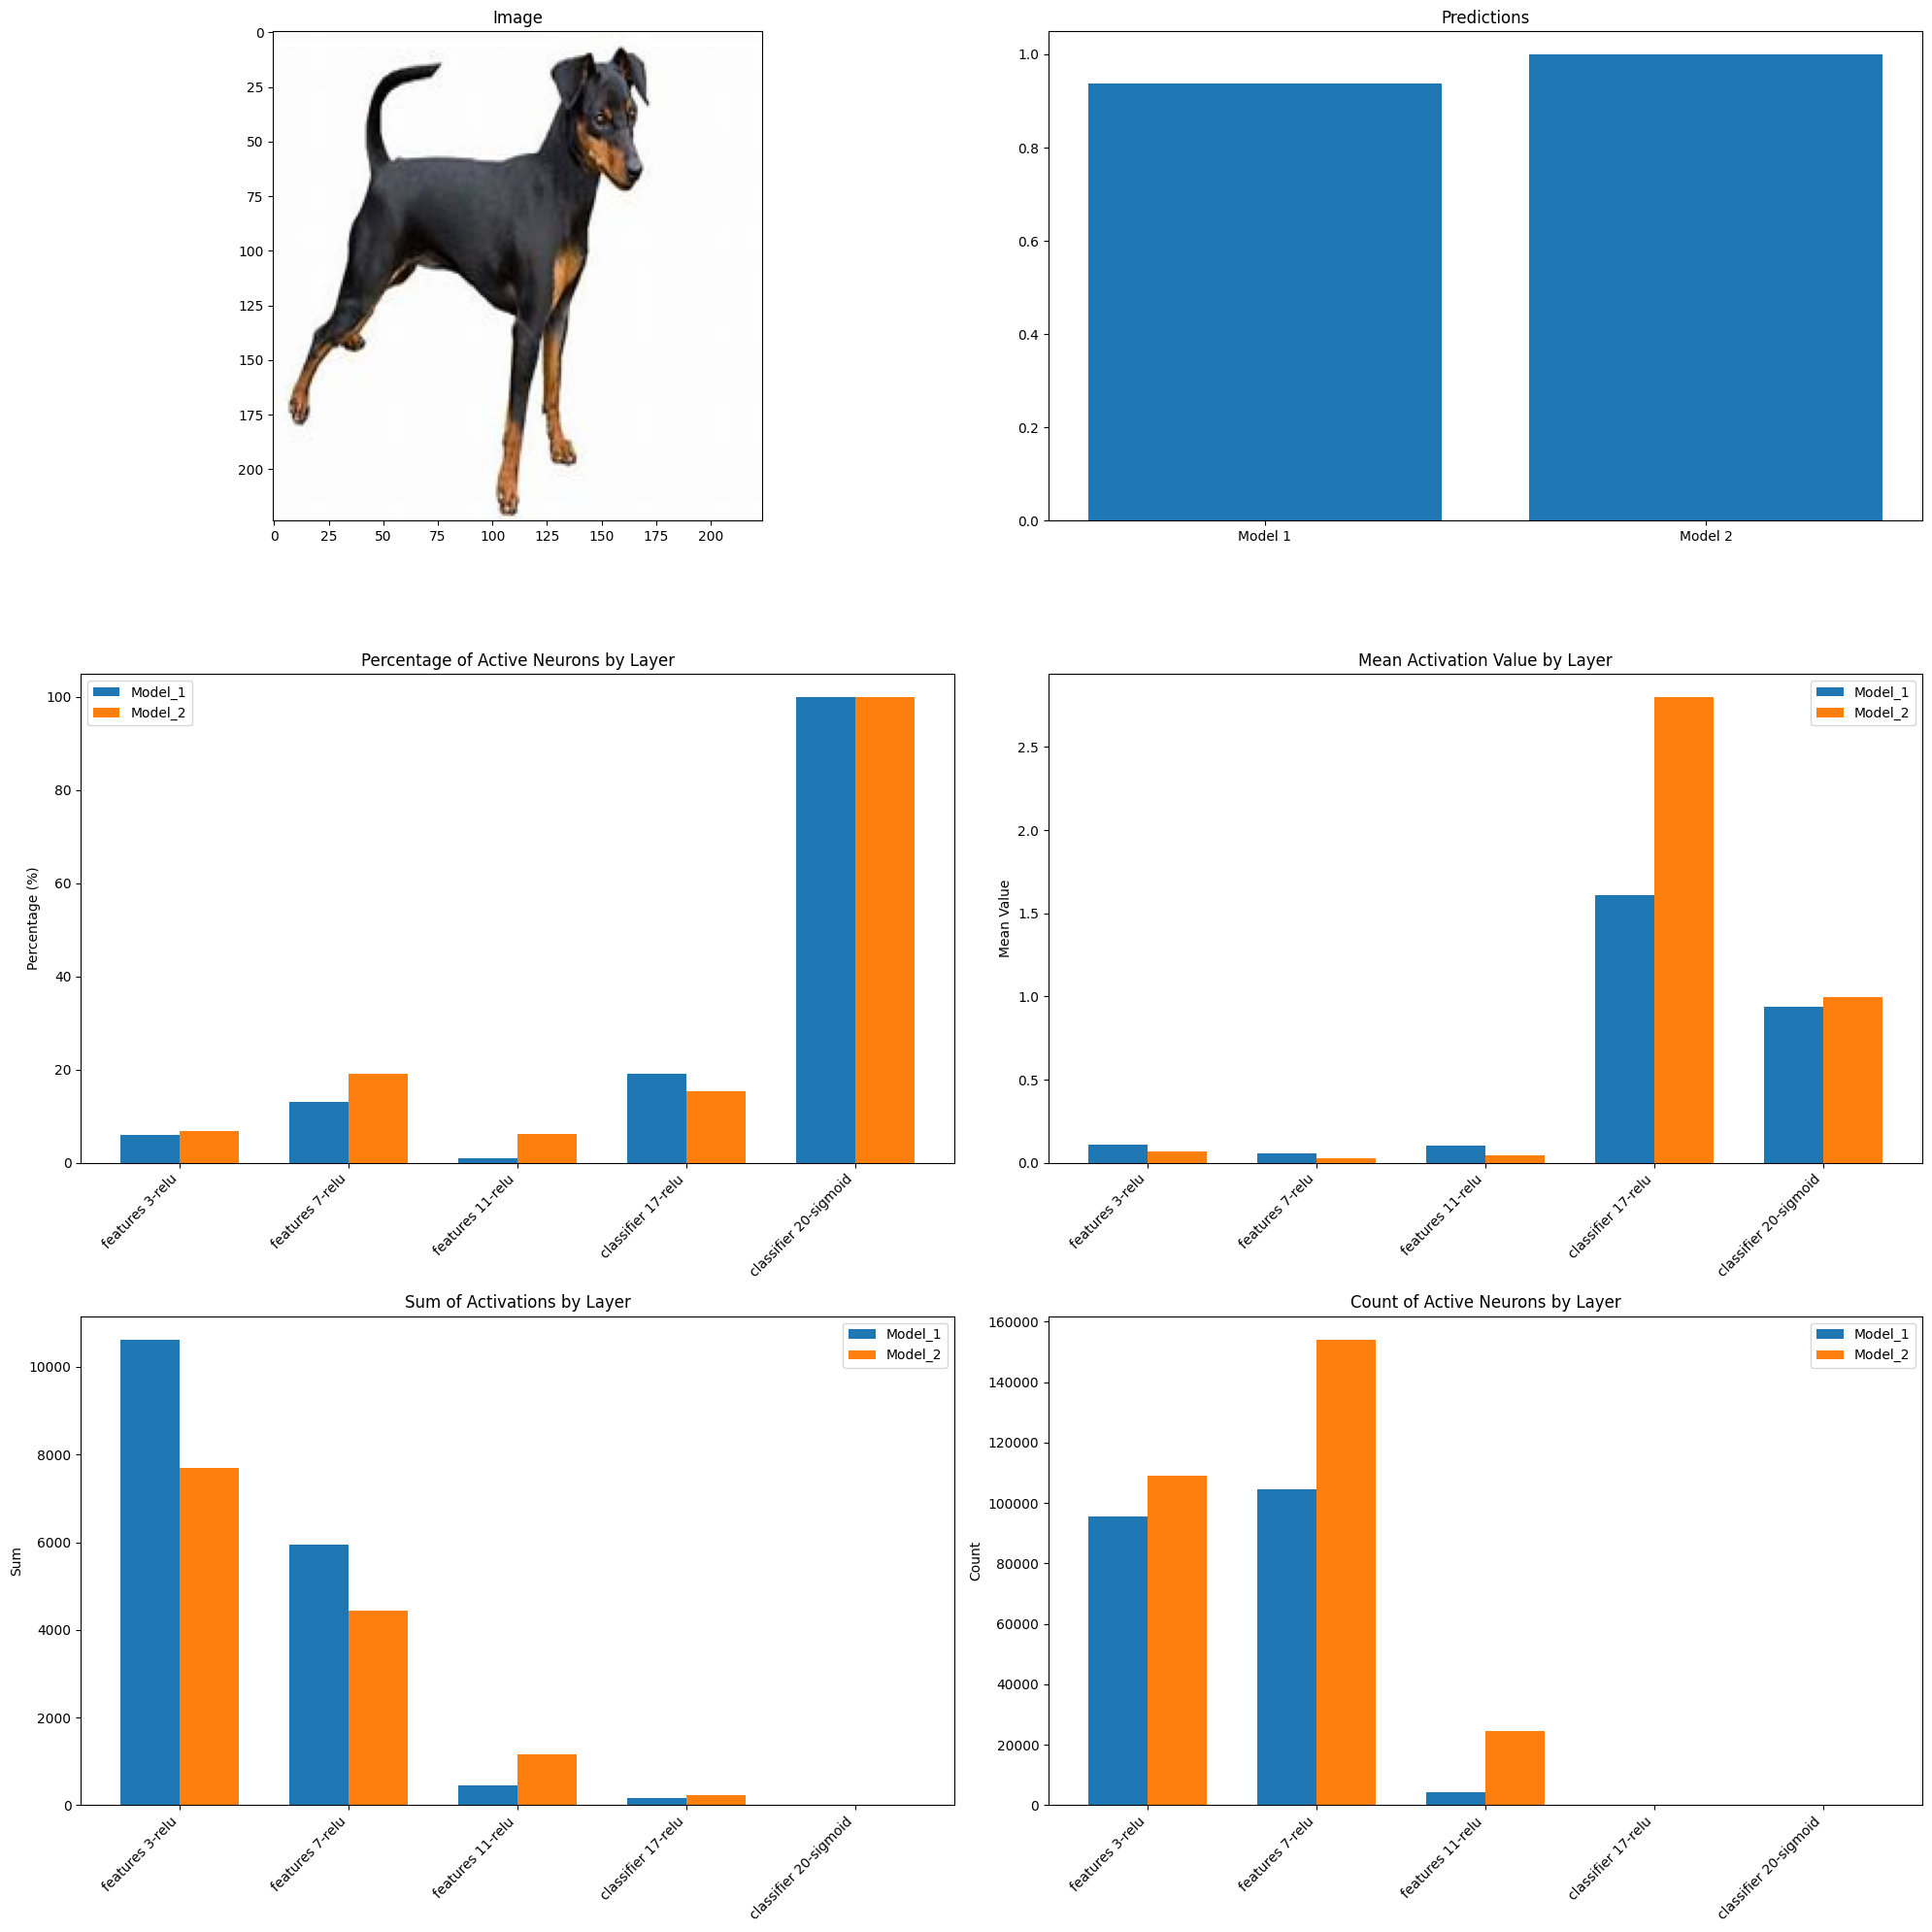


Combined Analysis for Both Models:
                       data_index  count_Model_1  count_Model_2  \
features 3-relu               104         170512         167602   
features 7-relu               104          57001         193731   
features 11-relu              104           9320           7176   
classifier 17-relu            104             29             47   
classifier 20-sigmoid         104              1              1   

                       total_neurons_Model_1  total_neurons_Model_2  \
features 3-relu                      1605632                1605632   
features 7-relu                       802816                 802816   
features 11-relu                      401408                 401408   
classifier 17-relu                       512                    512   
classifier 20-sigmoid                      1                      1   

                       percentage_active_Model_1  percentage_active_Model_2  \
features 3-relu                        10.619619       

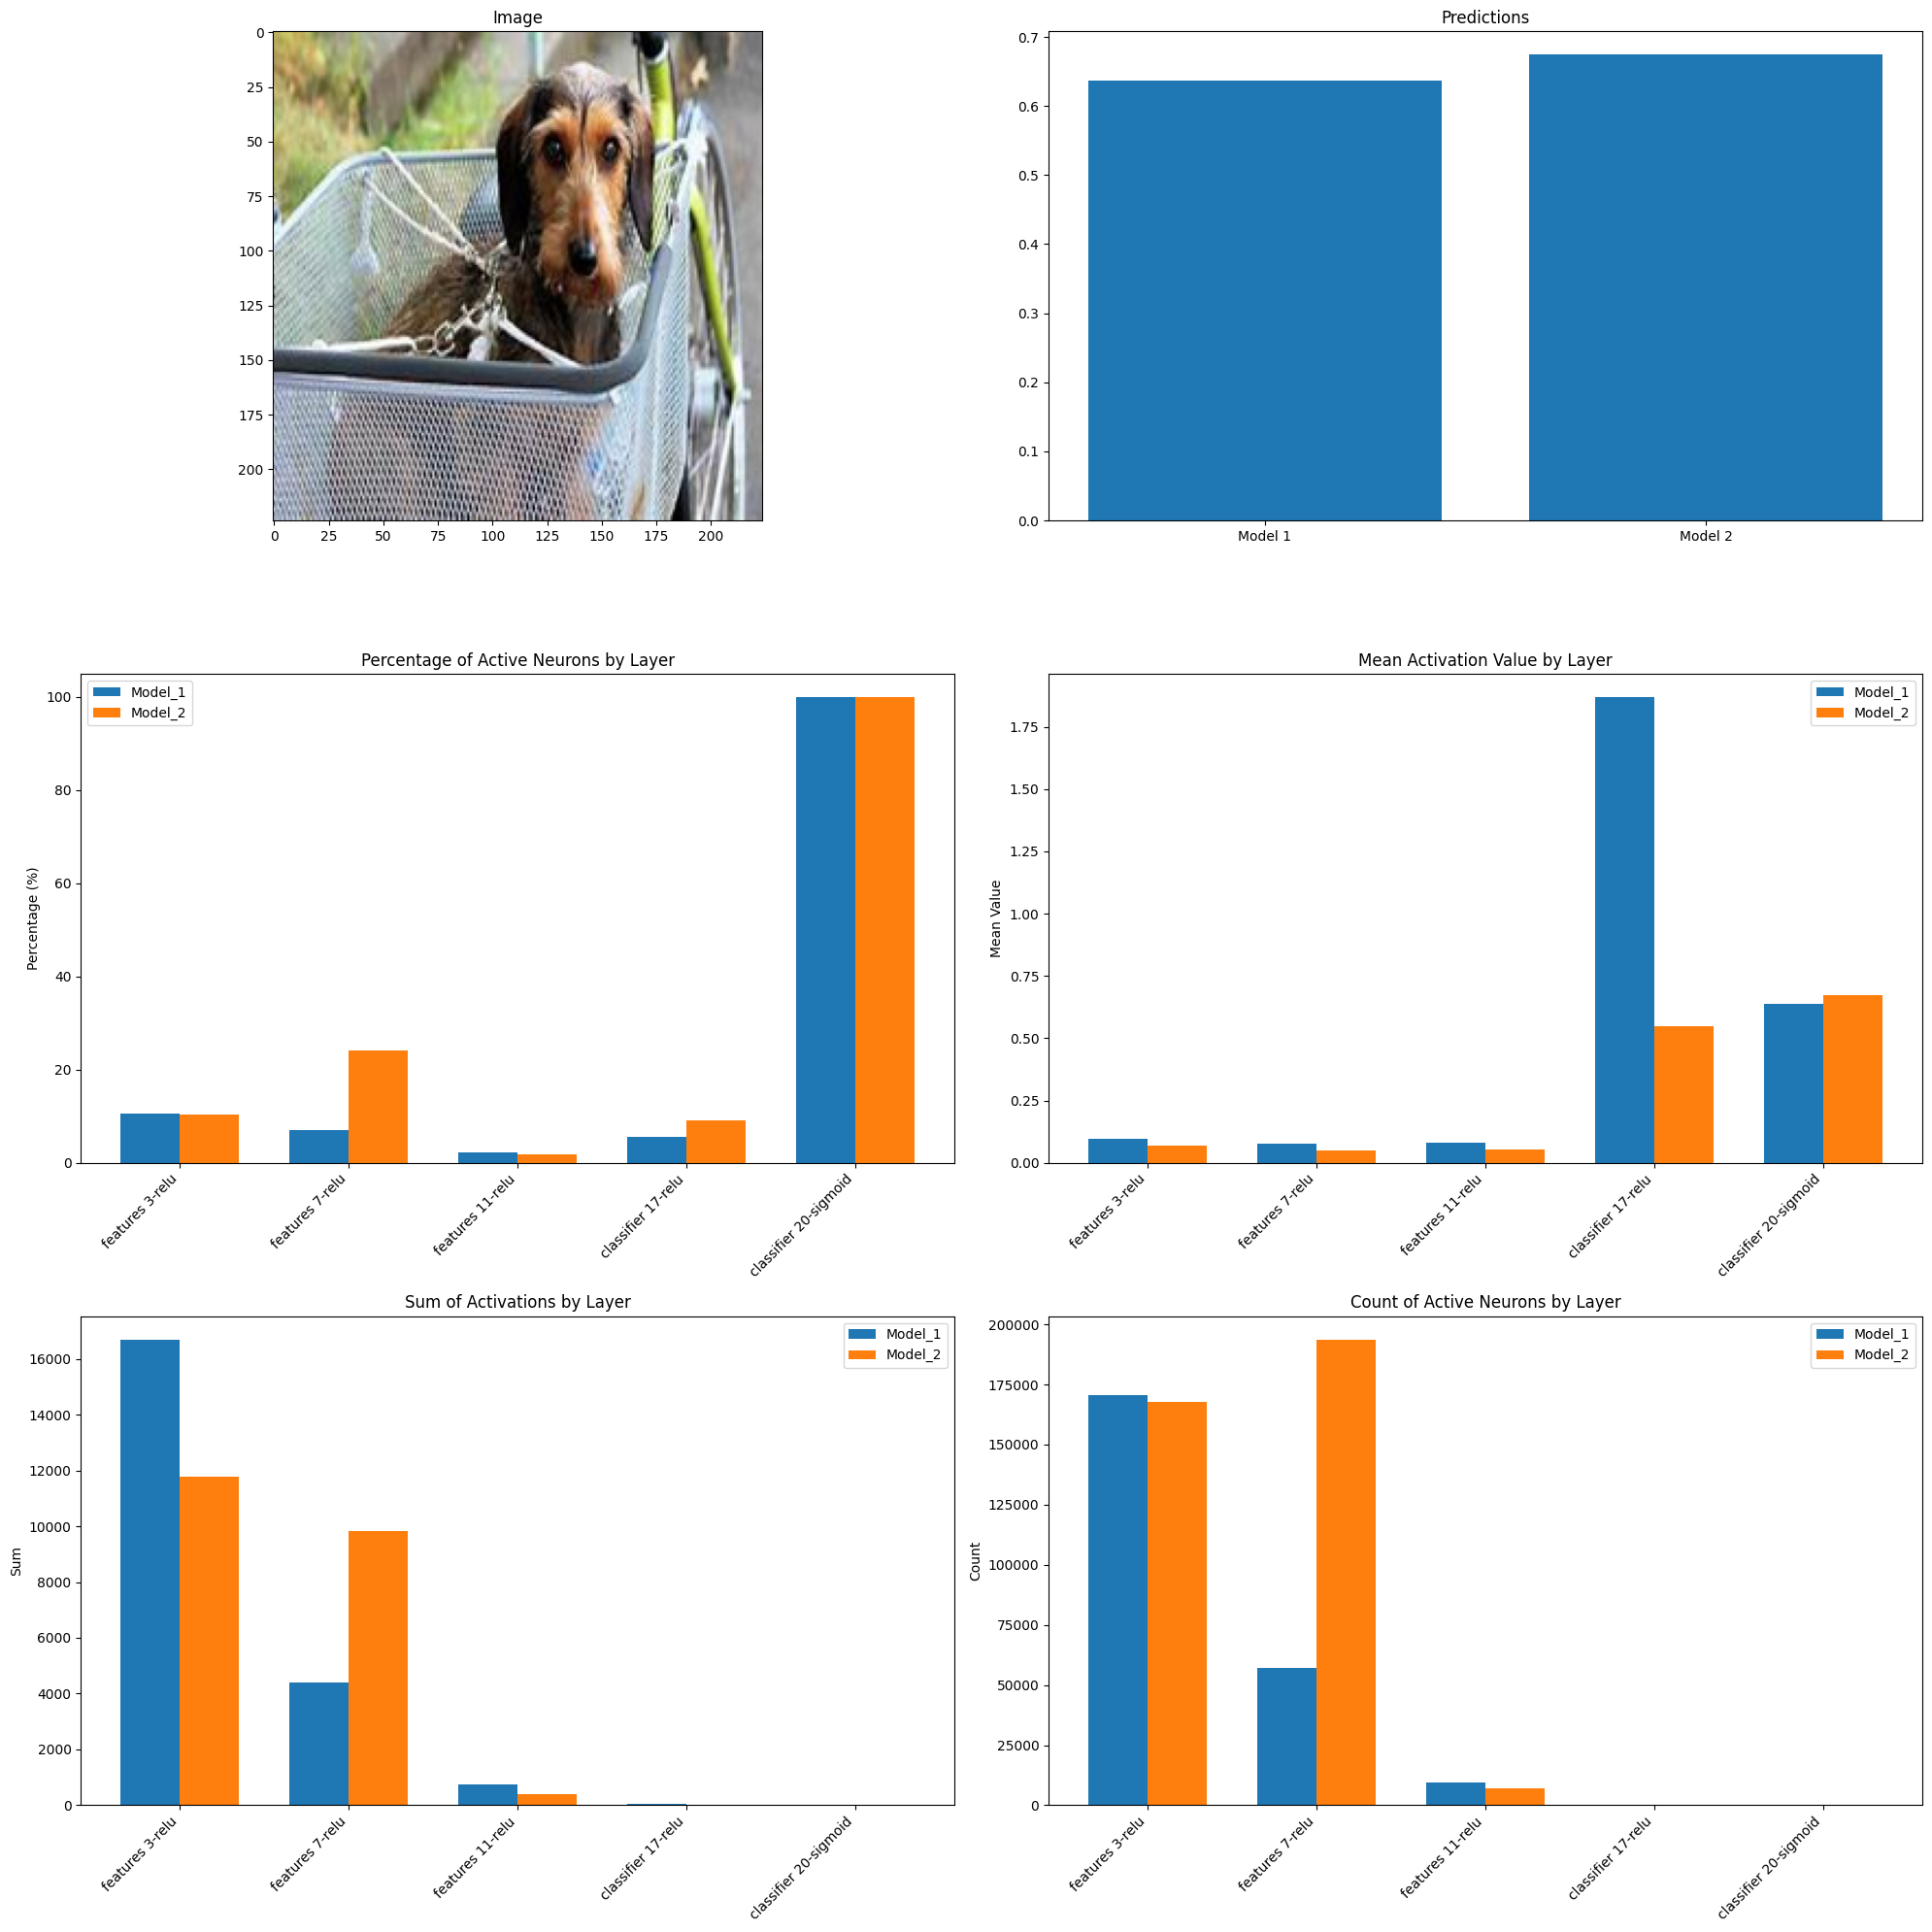


Combined Analysis for Both Models:
                       data_index  count_Model_1  count_Model_2  \
features 3-relu               105         131016         140520   
features 7-relu               105          87476         164411   
features 11-relu              105           8346          13154   
classifier 17-relu            105             49             59   
classifier 20-sigmoid         105              1              1   

                       total_neurons_Model_1  total_neurons_Model_2  \
features 3-relu                      1605632                1605632   
features 7-relu                       802816                 802816   
features 11-relu                      401408                 401408   
classifier 17-relu                       512                    512   
classifier 20-sigmoid                      1                      1   

                       percentage_active_Model_1  percentage_active_Model_2  \
features 3-relu                         8.159778       

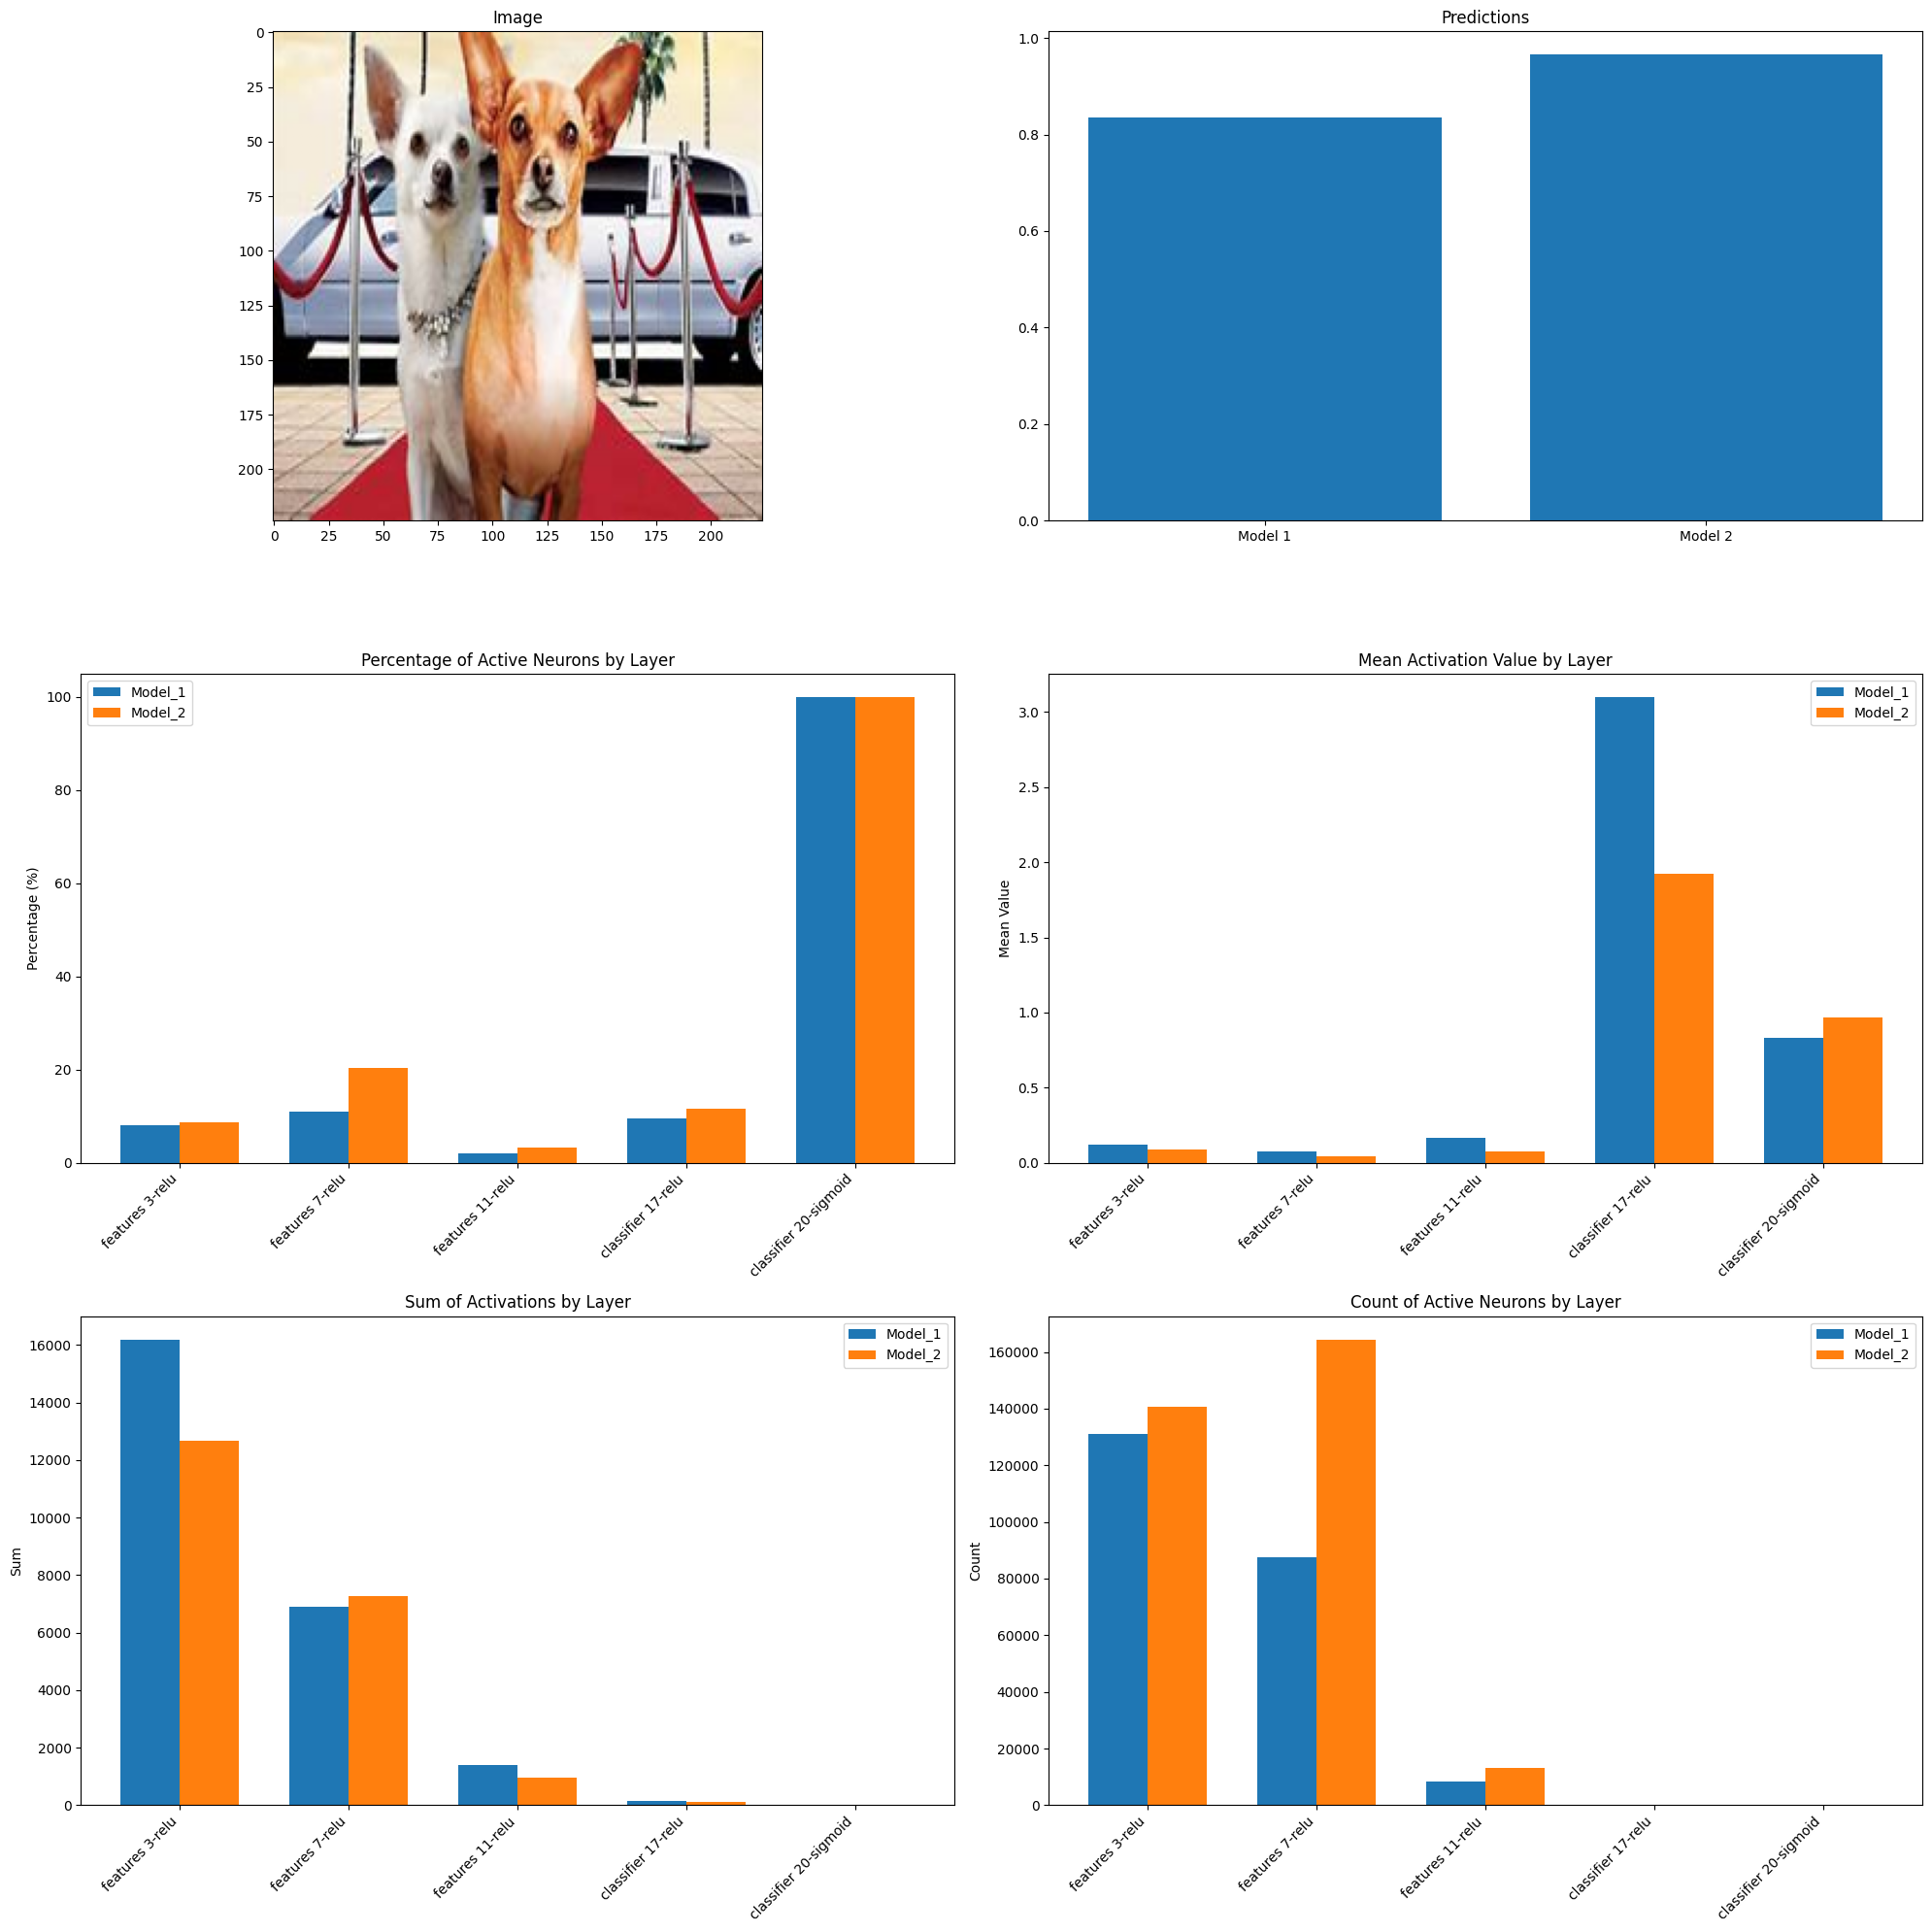


Combined Analysis for Both Models:
                       data_index  count_Model_1  count_Model_2  \
features 3-relu               106         135902         194413   
features 7-relu               106          87171         191543   
features 11-relu              106           6380           9479   
classifier 17-relu            106             33             56   
classifier 20-sigmoid         106              1              1   

                       total_neurons_Model_1  total_neurons_Model_2  \
features 3-relu                      1605632                1605632   
features 7-relu                       802816                 802816   
features 11-relu                      401408                 401408   
classifier 17-relu                       512                    512   
classifier 20-sigmoid                      1                      1   

                       percentage_active_Model_1  percentage_active_Model_2  \
features 3-relu                         8.464081       

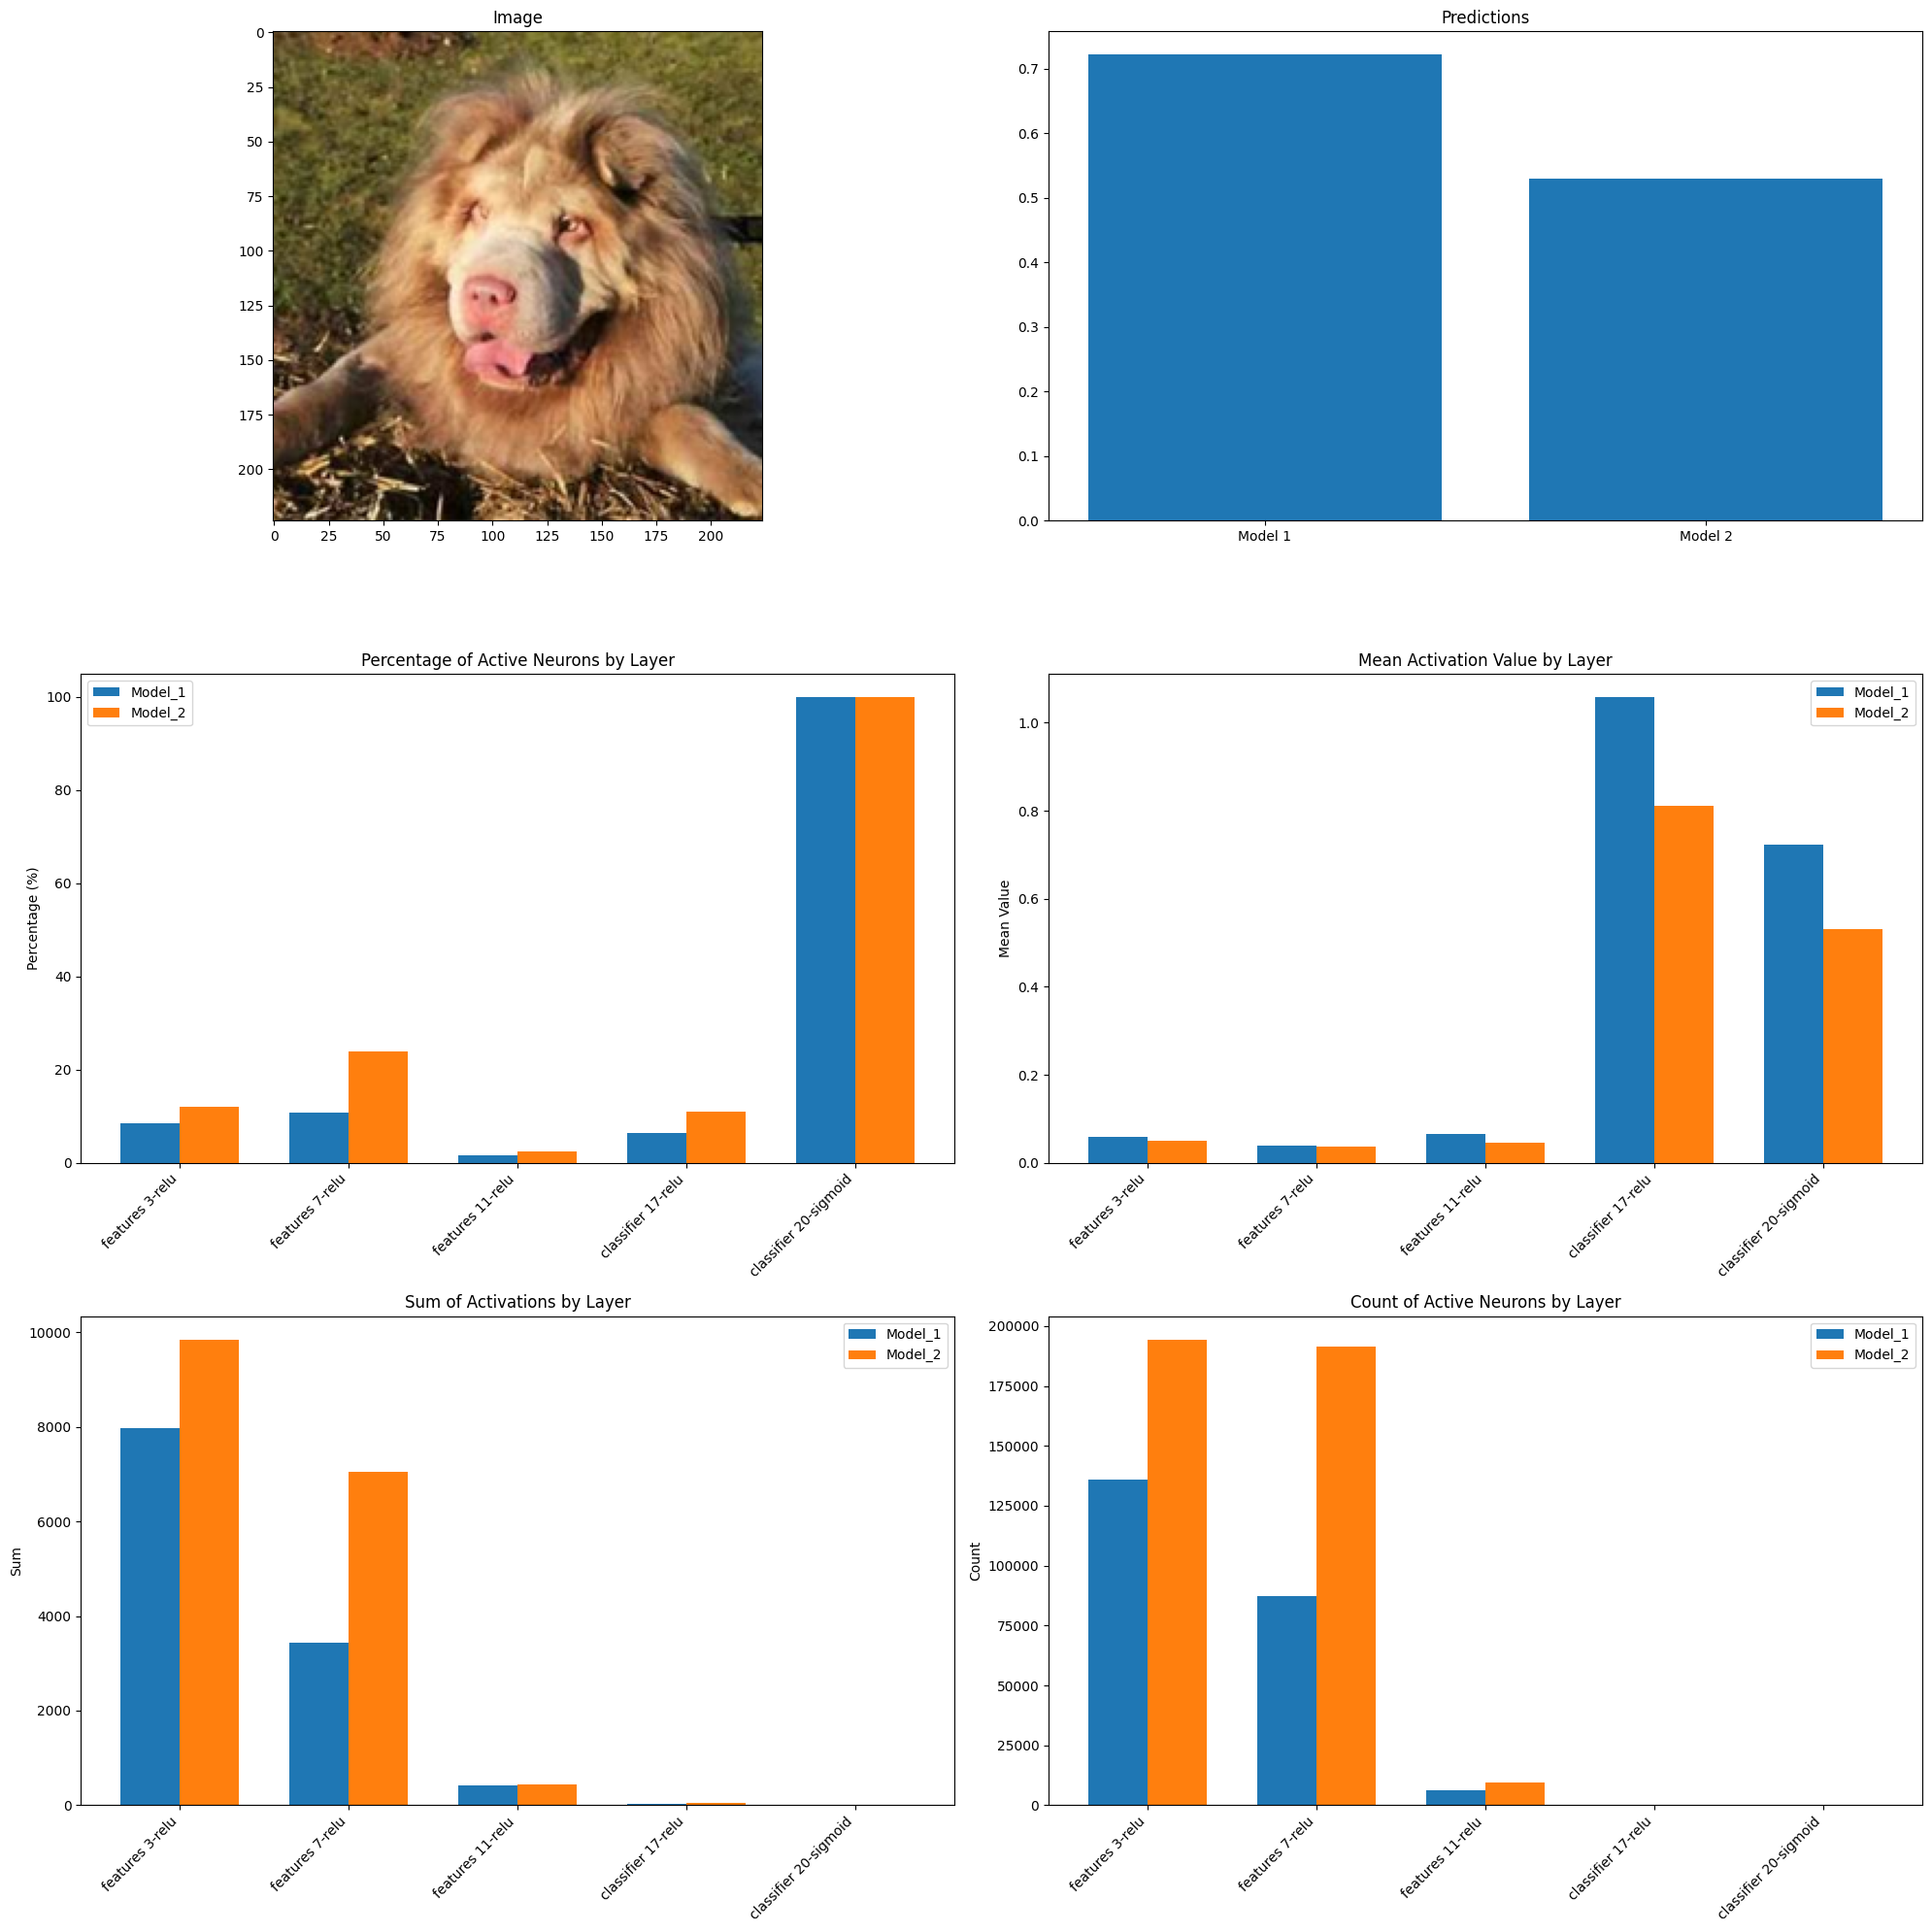


Combined Analysis for Both Models:
                       data_index  count_Model_1  count_Model_2  \
features 3-relu               107          50385          49412   
features 7-relu               107          85486         178082   
features 11-relu              107           3738          27610   
classifier 17-relu            107             71             62   
classifier 20-sigmoid         107              1              1   

                       total_neurons_Model_1  total_neurons_Model_2  \
features 3-relu                      1605632                1605632   
features 7-relu                       802816                 802816   
features 11-relu                      401408                 401408   
classifier 17-relu                       512                    512   
classifier 20-sigmoid                      1                      1   

                       percentage_active_Model_1  percentage_active_Model_2  \
features 3-relu                         3.138017       

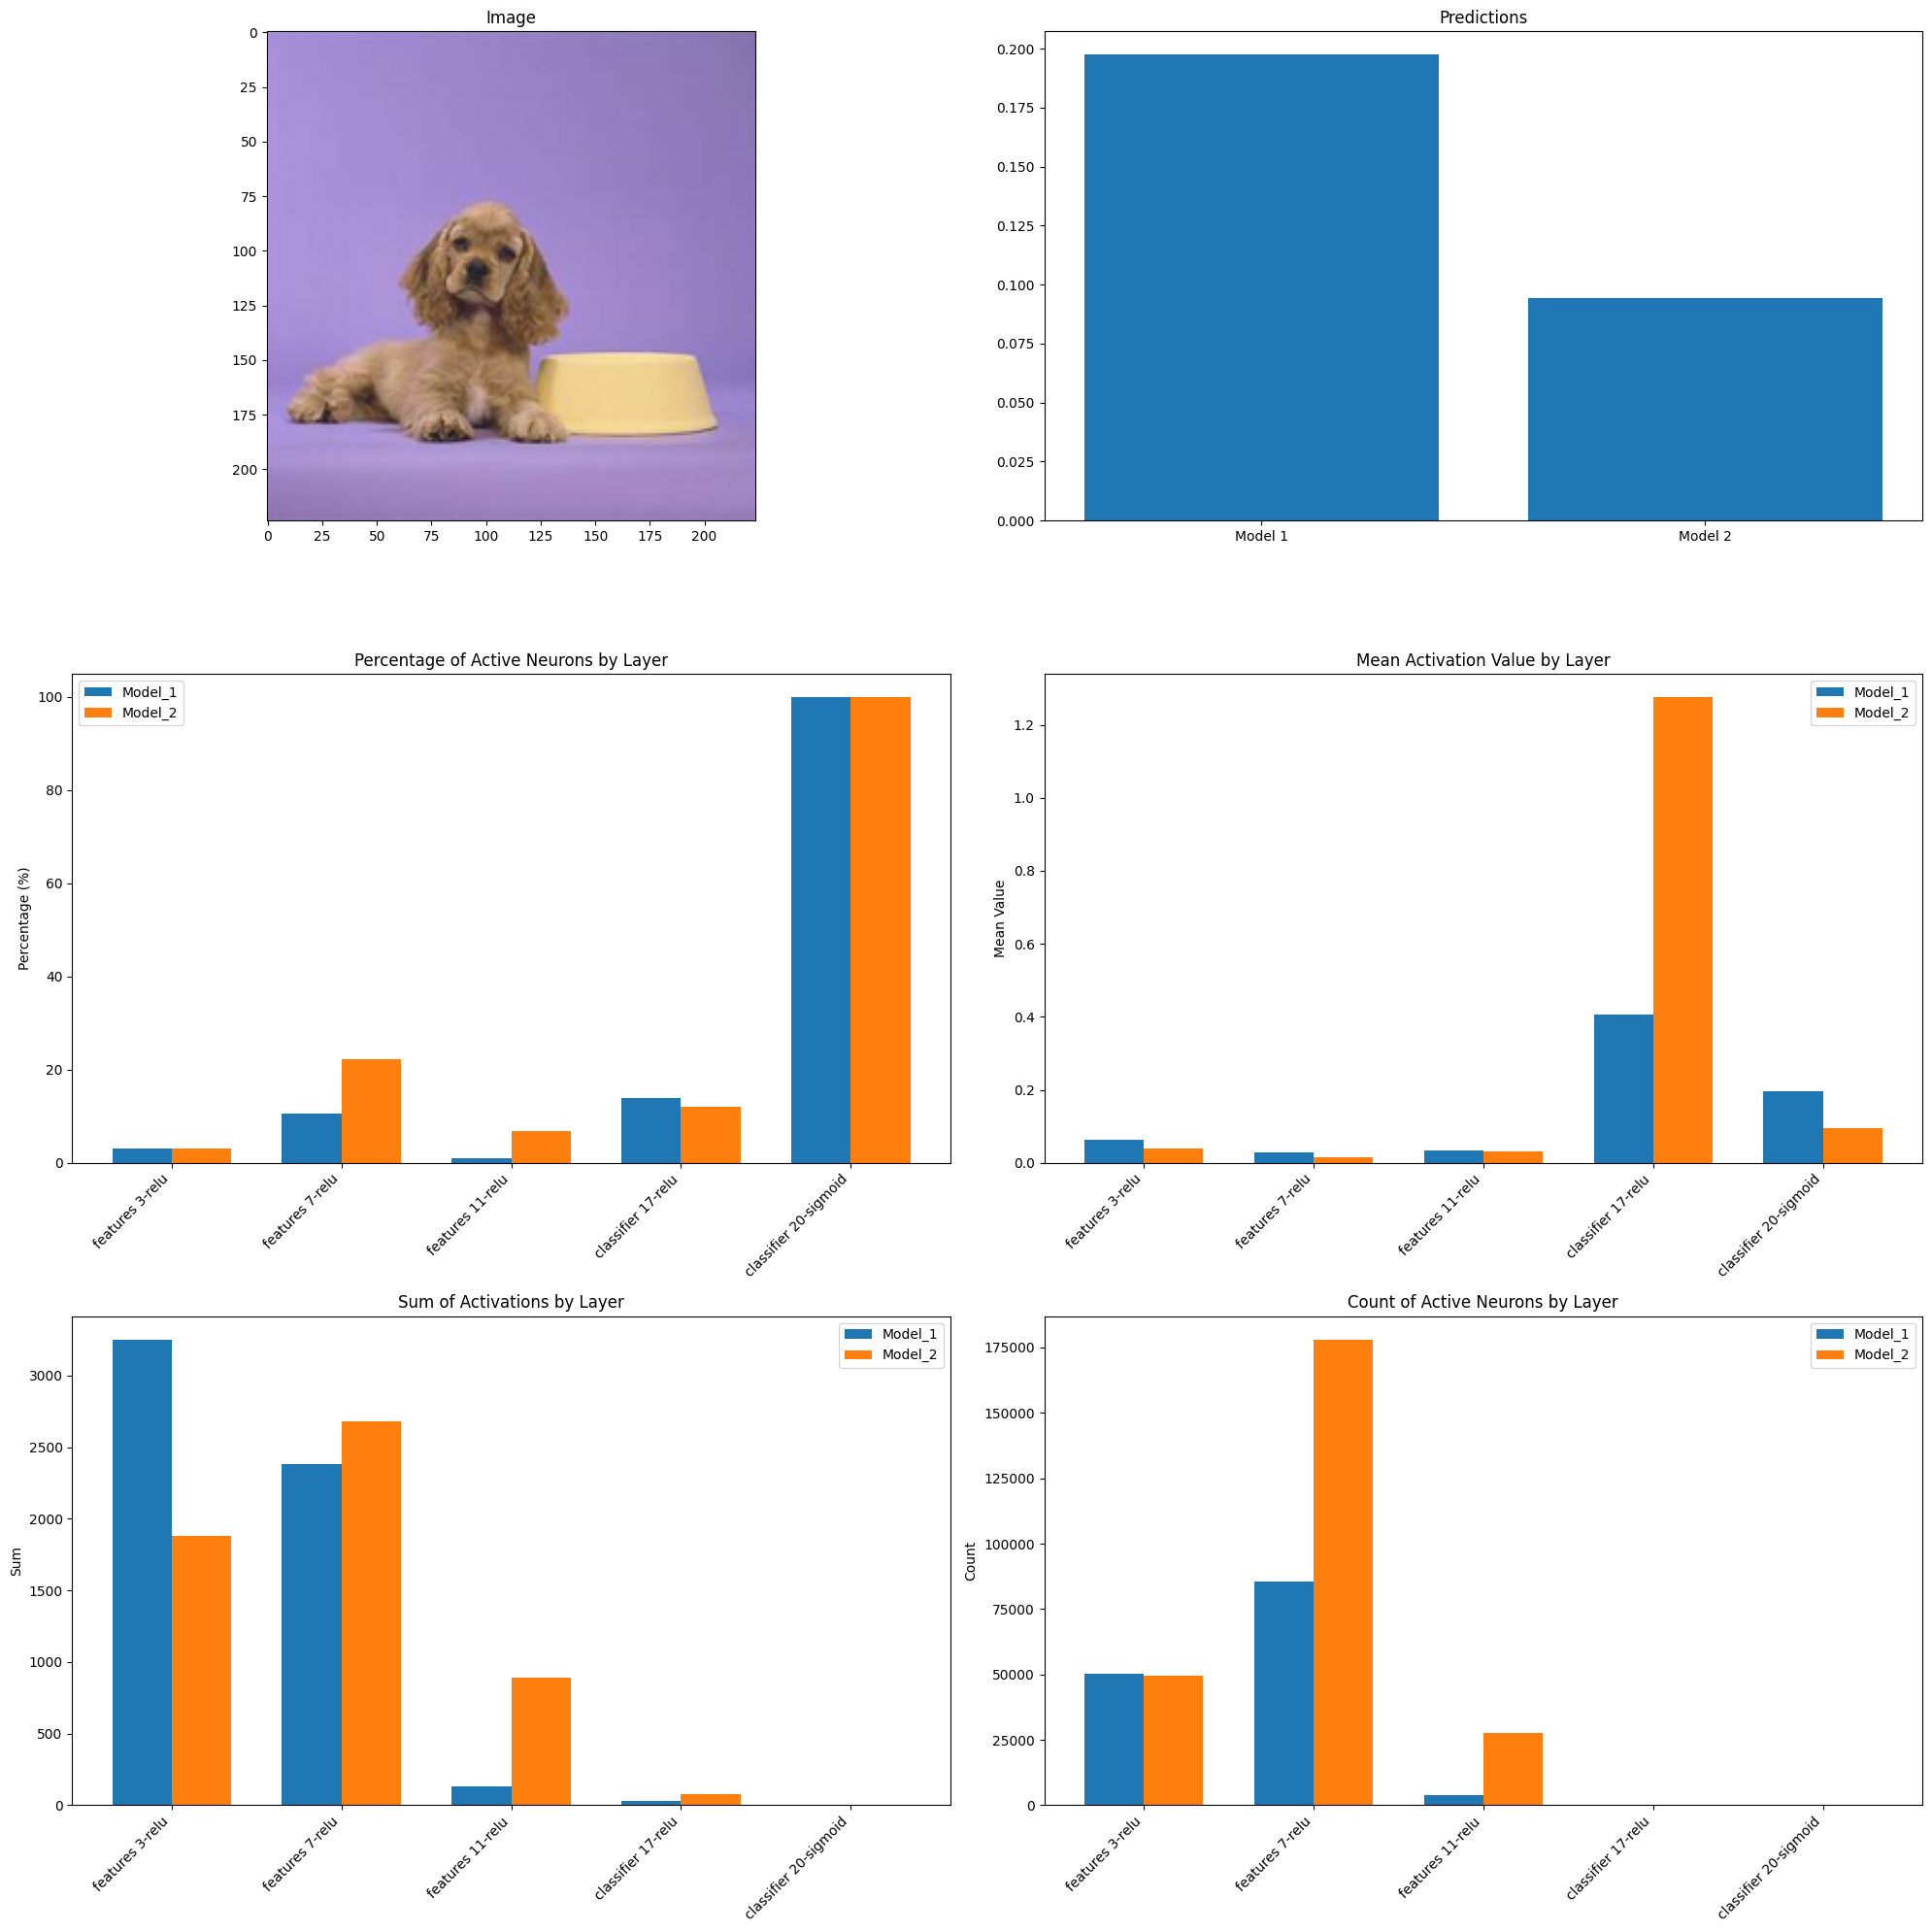


Combined Analysis for Both Models:
                       data_index  count_Model_1  count_Model_2  \
features 3-relu               108         249858         313024   
features 7-relu               108          99086         139127   
features 11-relu              108           3927          17679   
classifier 17-relu            108             91             46   
classifier 20-sigmoid         108              1              1   

                       total_neurons_Model_1  total_neurons_Model_2  \
features 3-relu                      1605632                1605632   
features 7-relu                       802816                 802816   
features 11-relu                      401408                 401408   
classifier 17-relu                       512                    512   
classifier 20-sigmoid                      1                      1   

                       percentage_active_Model_1  percentage_active_Model_2  \
features 3-relu                        15.561349       

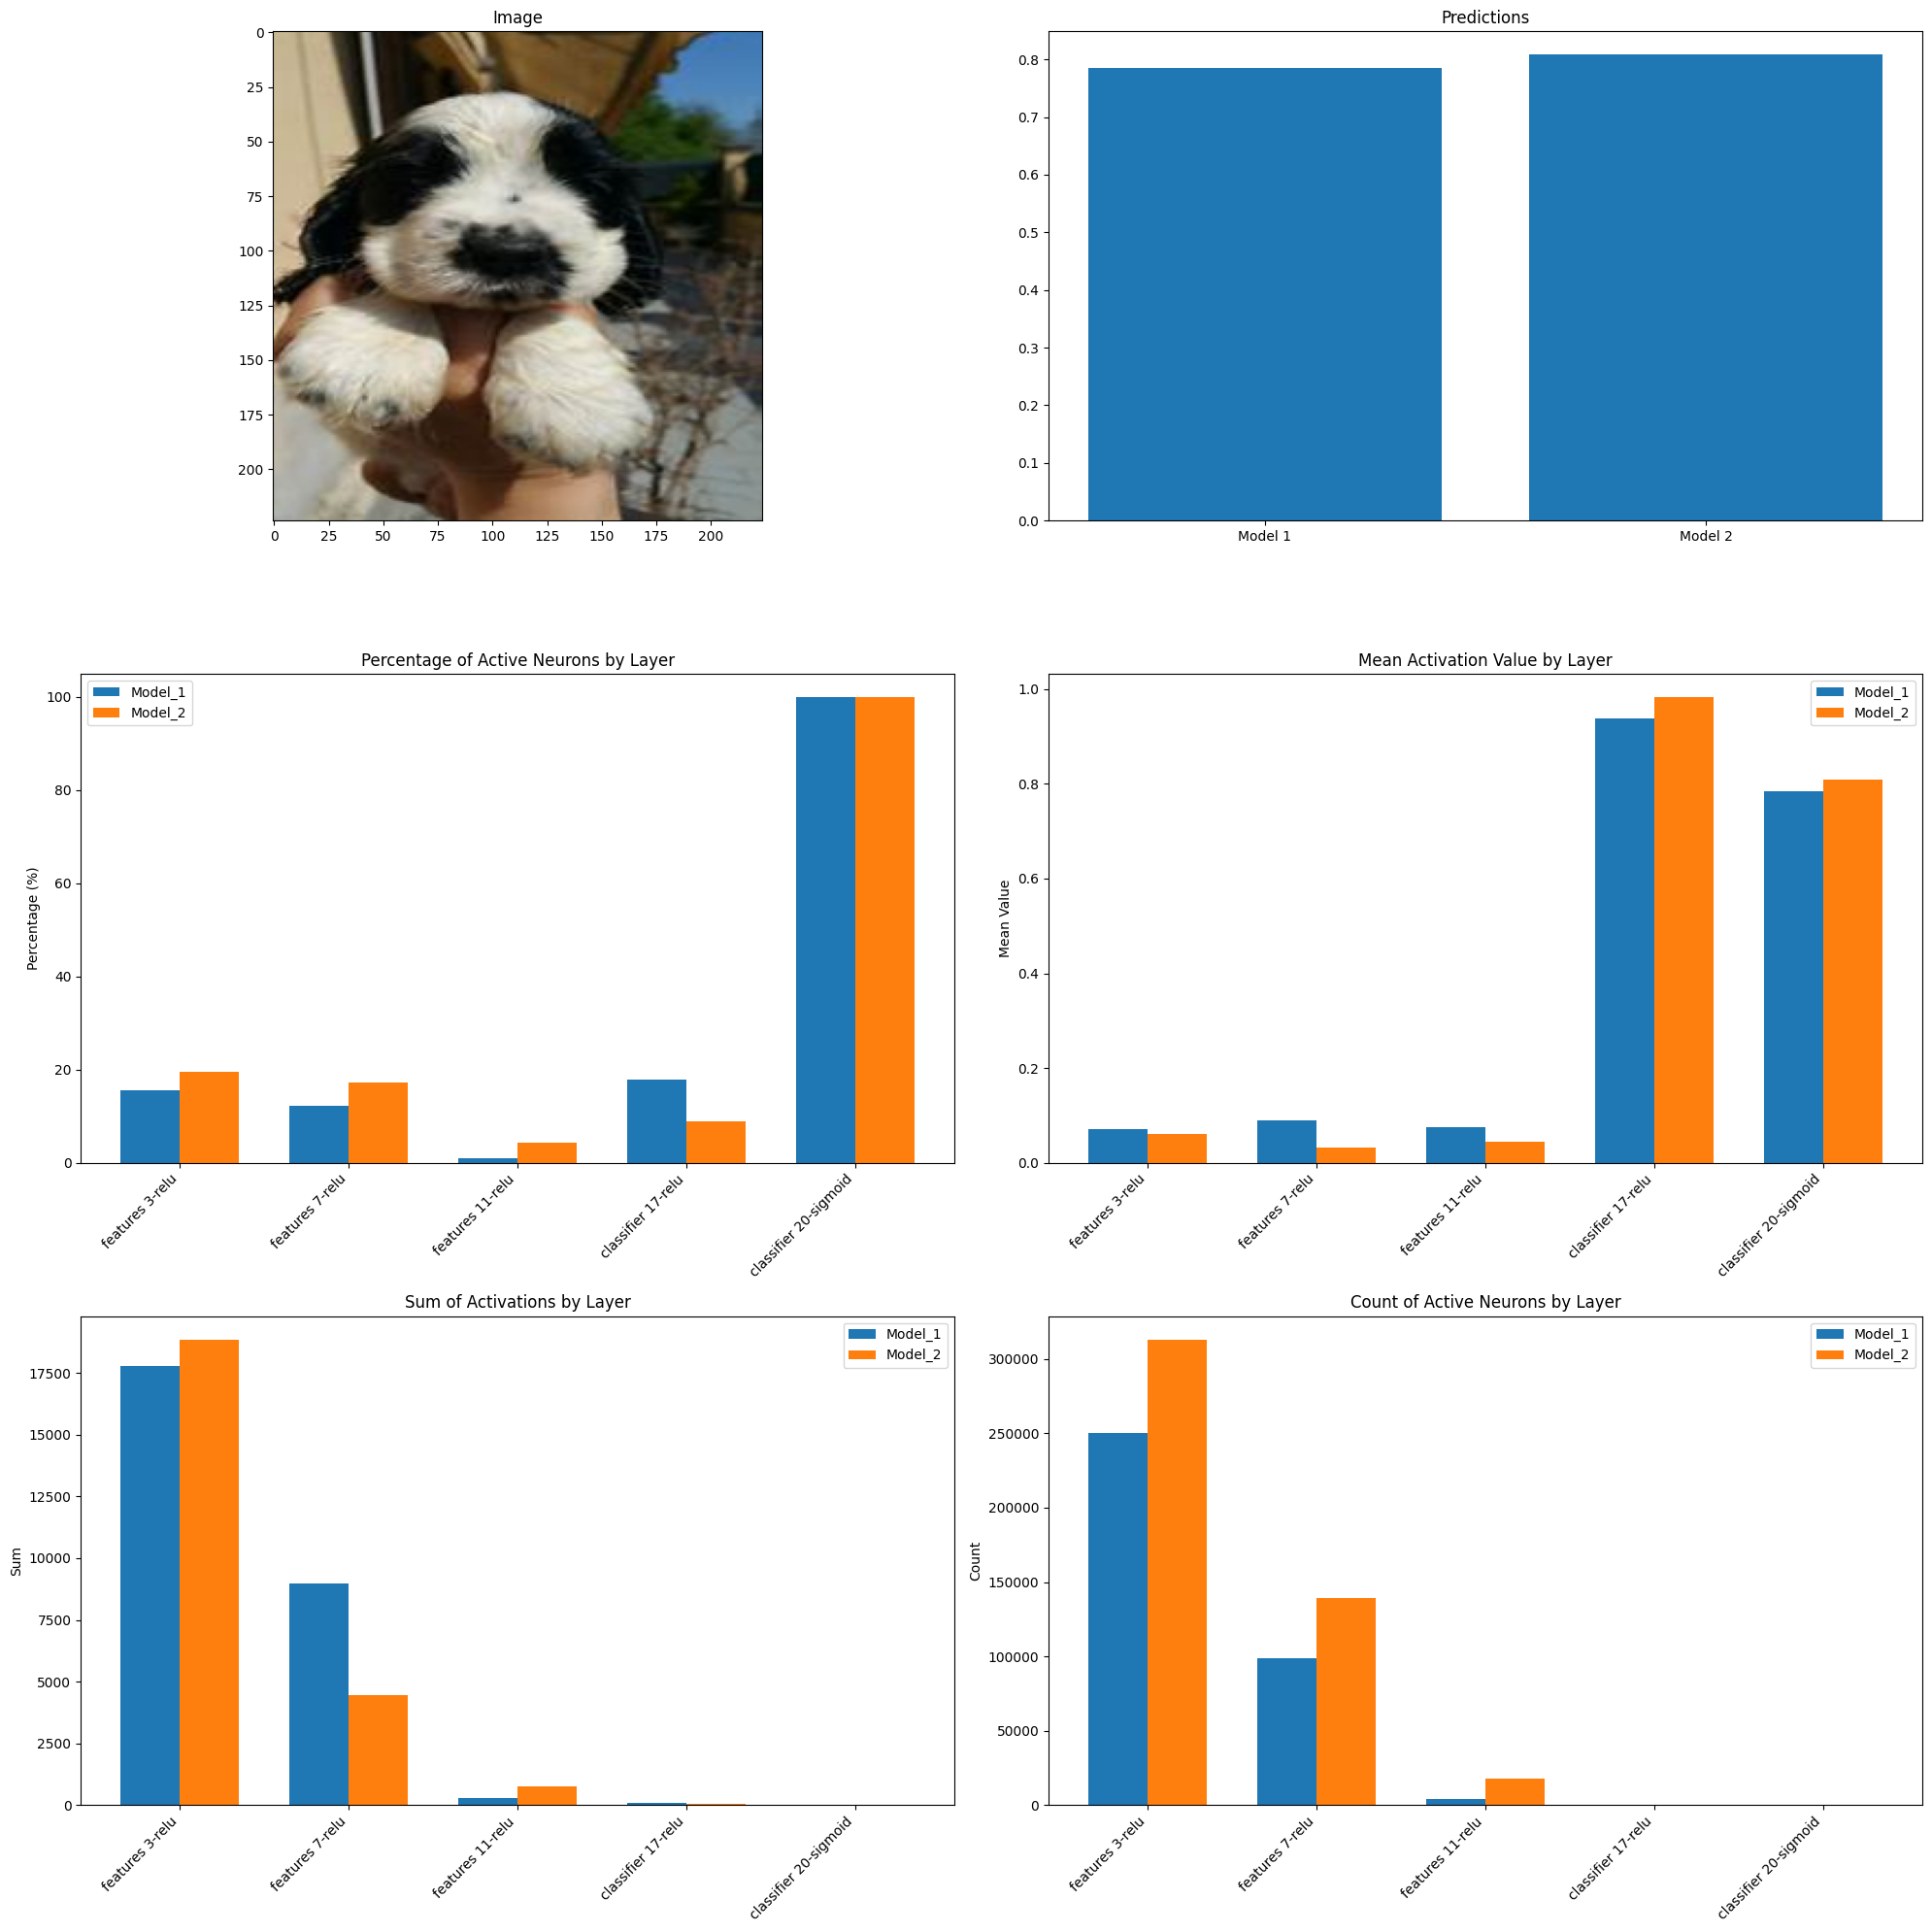


Combined Analysis for Both Models:
                       data_index  count_Model_1  count_Model_2  \
features 3-relu               109         151239         166575   
features 7-relu               109          84113         166302   
features 11-relu              109           5194          17829   
classifier 17-relu            109             50             67   
classifier 20-sigmoid         109              1              1   

                       total_neurons_Model_1  total_neurons_Model_2  \
features 3-relu                      1605632                1605632   
features 7-relu                       802816                 802816   
features 11-relu                      401408                 401408   
classifier 17-relu                       512                    512   
classifier 20-sigmoid                      1                      1   

                       percentage_active_Model_1  percentage_active_Model_2  \
features 3-relu                         9.419282       

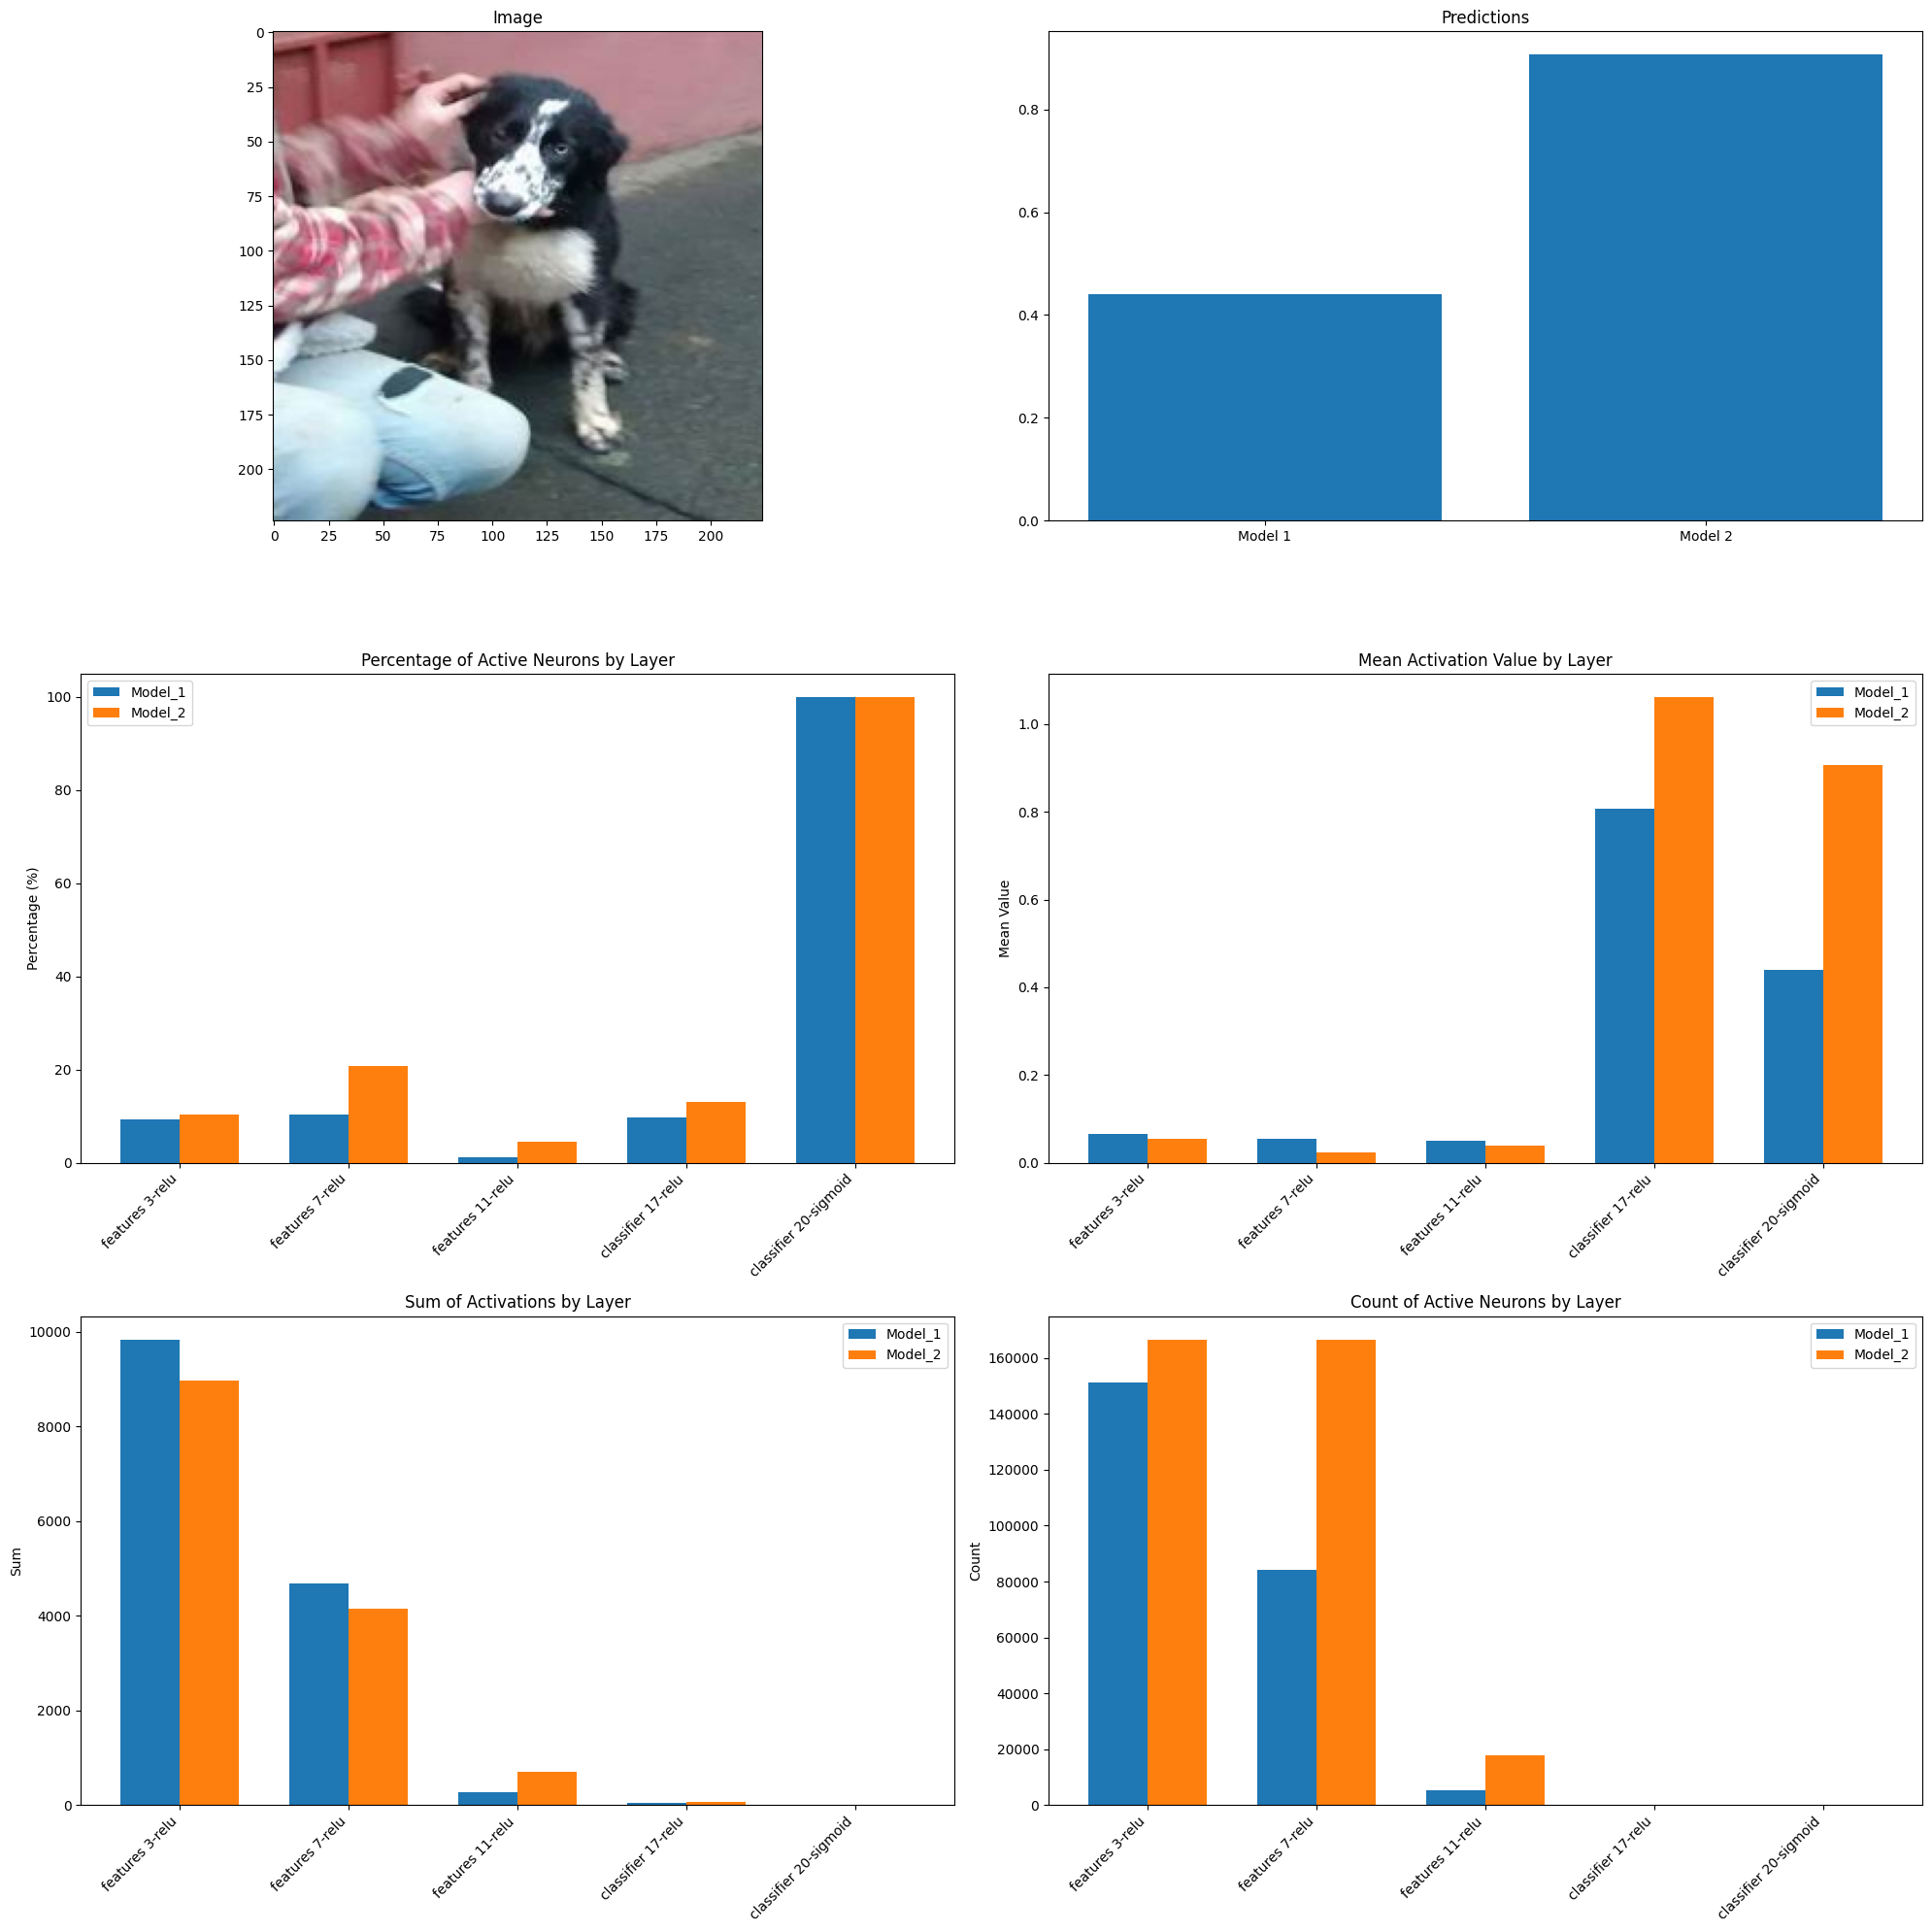

In [166]:
images = [(img, idx) for idx, (img, label) in enumerate(dataSets["Model_1:Test"].dataset) 
            if label == 1][:10]

all_dfs = []

for image, pic_index in images:
    activation_values = {"Model_1":{},
                        "Model_2":{}}

    hooks1, layers1 = register_hooks(model_1, "Model_1")
    hooks2, layers2 = register_hooks(model_2, "Model_2")

    with torch.no_grad():
        pred1 = model_1(image.unsqueeze(0).to(DEVICE))
        pred2 = model_2(image.unsqueeze(0).to(DEVICE))
        

    df_combined = analyze_positive_activations(
        activation_values["Model_1"], 
        activation_values["Model_2"],
        layers1,
        layers2,
        pic_index,
        "Model_1",
        "Model_2",
        image,
        pred1,
        pred2
    )

    # Add image index as a column
    df_combined['image_index'] = pic_index
    
    # Add to list
    all_dfs.append(df_combined)


    # Remove hooks
    for hook in hooks1 + hooks2:
        hook.remove()

In [ ]:
# Concatenate all DataFrames 
combined_df = pd.concat(all_dfs, axis=0)

# Reset index to include both layer name and image index
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index': 'layer_name'})

# Save the final combined DataFrame
combined_df.to_csv('model_comparison_stats.csv', index=False)

# Print the final combined DataFrame
print("\nCombined statistics for all images:")
print(combined_df)



Combined statistics for all images:
               layer_name  data_index  count_Model_1  count_Model_2  \
0         features 3-relu         100         100227         110856   
1         features 7-relu         100          97621         168206   
2        features 11-relu         100           4551          20787   
3      classifier 17-relu         100             49             71   
4   classifier 20-sigmoid         100              1              1   
5         features 3-relu         101         218946         248225   
6         features 7-relu         101          85727         159765   
7        features 11-relu         101           6032          10318   
8      classifier 17-relu         101             59             79   
9   classifier 20-sigmoid         101              1              1   
10        features 3-relu         102         100963         133453   
11        features 7-relu         102         109995         185482   
12       features 11-relu         102   